# 3 -  2-Dimensional Inference in $\theta - \nu$ Space and Replacing Observed Data with Test Statistics 


# 2D inference on $\theta$ and $\nu$

Ali Al Kadhim and Harrison B. Prosper <br>
Department of Physics, Florida State University <br>



In [1]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
#Harrison fonts
FONTSIZE=18
font = {'family': 'serif', 'weight':'normal', 'size':FONTSIZE}
mp.rc('font', **font)
mp.rc('text',usetex=True)

import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

try:
    import optuna
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
# import sympy as sy
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this
import ipywidgets as wid; wid.HTMLMath('$\LaTeX$')
%matplotlib inline

### import utils

In [2]:
try:
    LFI_PIVOT_BASE = os.environ['LFI_PIVOT_BASE']
    print('BASE directoy properly set = ', LFI_PIVOT_BASE)
    utils_dir = os.path.join(LFI_PIVOT_BASE, 'utils')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    from utils import *
except Exception:
    print("""BASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/LFI_HEP


## Recall that when we wanted to make inference on $\theta$ alone,

$$ \lambda(\theta) \equiv - 2 \log{\frac{p(n,m|\theta, \hat{\nu}(\theta) )}{ p(n,m|\hat{\theta}, \hat{\nu}(\theta) )}} = -2 \log \frac{L_{\text{prof}} \big(\theta \big) }{L_{\text{prof}} \big( \hat{\theta} \big)}, \tag{4}$$


where $L_{\text{prof}} \big( n, m, \theta, \hat{\nu}(\theta) \big)$ is the profiled likelihood - that is - the likelihood function when the nuissance parameters are replaced by their maximum likelihood estimates (MLE) for a given value of the parameter of interest.


$$
L_{\text{prof}}(\theta) \equiv \frac{e^{-(\theta+\hat{\nu})} (\theta+\hat{\nu})^N }{N !} \ \frac{e^{-\hat{\nu}} \hat{\nu}^M}{M !} \tag{5}.
$$




The MLE estimate $\hat{\nu}(\theta)$ is attained by minimizing the conditional likelihood

$$\frac{\partial \log{p(n,m|\theta,\nu)}}{ \partial \nu} =0$$

whilst keeping $\theta$ constant, leading to 

$$\log{p(n,m|\theta,\nu)} = -(\theta+\nu)+n\log{(\theta+\nu)|-\nu+m\log{\nu}} + \text{constants}$$

$$\hat{\nu}(\theta)=\left(g+\sqrt{g^2 + 8 m \theta} \right)/4,$$
where $g \equiv n+m-2 \theta$.



or equivalently

$$\frac{\partial \log{L(\theta)}}{ \partial \nu}|_{\nu=\hat{\nu}} =0,$$ 






leading to 

$$\log{L(\theta)} = -(\theta+\nu)+n\log{(\theta+\nu)|-\nu+m\log{\nu}} + \text{constants}$$




We have a nice functional form for $\lambda$, where The MLE of $\hat{\theta}$ is given by

$$\hat{\theta}^{\text{(MLE)}}=n-m.$$





Low-count data can sometimes yield spurious results, where the MLE of a parameter of interest $\theta$, could yield a negative result. In the case that $\theta$ is the cross section, yielding a negative result is non-physical, which leads to the ad-hoc fix: taking ignoring the MLE solution and taking $\hat{\theta}=0$ when $n<m$:


$$\hat{\theta}^{\text{(non-MLE)}} =\left\{
\begin{array}{ll}
    n-m & \quad  n>m \\
    0 & \quad n \le m
\end{array}
\right.
$$






$$
L_{\text{prof}}(\theta,\nu) \equiv \frac{e^{-(\hat{\theta}+\hat{\nu})} (\hat{\theta}+\hat{\nu})^N }{N !} \ \frac{e^{-\hat{\nu}} \hat{\nu}^M}{M !}.
$$


If we want to do inference on $(\theta,\nu)$ simultaneously, we use a different test statistic, since in this case $\nu$ is not known, and hence $\nu$ is needed in the training as well as the evaluation of the model. (recal that for $\lambda_{NP,\theta}$ we had $\nu$ fixed for the training and evaluation, but $\nu$ was also generated in the algorithm internally. Not a good explanation but this is jut informal notes.)

$$ \lambda_{2D} (\theta,\nu)= -2 \log \frac{L_{\text{prof}} \big(\theta,\nu \big) }{L_{\text{prof}} \big( \hat{\hat{\theta}},\hat{\hat{\nu}} \big)}, \tag{4}$$


Where $\hat{\hat{\theta}},\hat{\hat{\nu}}$ are the global maxima.


Just like in the 1D case $\lambda_{NP,1D} \rightarrow \chi^2_1$ so that the confidence interval can be found by $\Delta \lambda_{NP,1} \le \chi^2_{1,1-\alpha}$, in 2D we have the same situation, where now it approaches a $\chi^2$ distribution with 2 free parameters.




In [3]:
def theta_hat_(n,m, MLE=True):
    theta_hat = n-m
    
    if not MLE:
        theta_hat = theta_hat * (theta_hat > 0)
    return theta_hat

def L_prof_global(n,m, MLE=True):
    # theta_hat = n-m
    theta_hat=theta_hat_(n,m,MLE)
    nu_hat = m
    p1=st.poisson.pmf(n, theta_hat+nu_hat)
    p2 = st.poisson.pmf(m, nu_hat)
    return p1*p2

In [4]:
def L_theta_nu(n,m,theta,nu):
    p1 = st.poisson.pmf(n, theta+nu)
    p2 = st.poisson.pmf(m, nu)
    return p1*p2

In [5]:
def lambda_test_2d(n,m, theta, nu, MLE=True):
    Ln= L_theta_nu(n,m,theta,nu)
    
    Ld= L_prof_global(n,m, MLE=True)
    eps=1e-14
    Ld=Ld+eps
    lambda_  = -2*np.log(Ln/Ld)
    return np.array(lambda_)

In [6]:
chi2_exp_size=int(1e5)

def run_sim_2d(theta, nu, MLE, lambda_size):
    """Sample n ~ Pois(theta+nu), 
              m ~ Pois(nu), 
    and compute 
              lambda(theta, n, m)
              
    return: (n, m, lambda_), where each are np arrays of length lambda_size
    """
    n = st.poisson.rvs(theta+nu, size=lambda_size)
    m = st.poisson.rvs(nu, size=lambda_size)
    lambda_ = lambda_test_2d(n, m, theta, nu)
    return (n, m, lambda_)

def run_sims(points, MLE):
    """
    Run an entire simulation, that is, generate n and m from 
    run_sim above, and calculate lambda, for
    
    input: a tuple of (theta, nu) scalars
    
    Reurns:df, lambda_results
    
    where lambda_results is a list of tuples 
        (n, m, lambda_, theta, nu)
    and df is just a dataframe of [n,m,lambda,theta,nu]

    """
    lambda_results=[]
    df=pd.DataFrame()
    for p in points:
        theta, nu = p
        df['theta']=theta
        df['nu']=nu
        n, m, lambda_ = run_sim_2d(theta, nu, MLE, lambda_size =chi2_exp_size)
        df['n'] = n
        df['m'] = m
        df['lambda']=lambda_
        lambda_results.append((n, m, lambda_, theta, nu))
    
        print( '\n \n (theta, nu) =  (%.f, %.f) \n ' % (theta, nu) )
        print(f'\t \t with associated n =  {n}, \n \n \t \t m = {m}, \n \n \t \t lambda = {lambda_}'  )
    return df, lambda_results

In [41]:
def make_hist_2d_data_2d_inference(Bprime,
              thetamin, thetamax,
              numin, numax, 
                      N, M,
               nbinstheta, nbinsnu,                    
                      MLE):

    theta = st.uniform.rvs(thetamin, thetamax, size=Bprime)
    nu = st.uniform.rvs(numin, numax, size=Bprime)
    n = st.poisson.rvs(theta + nu, size=Bprime)
    m = st.poisson.rvs(nu, size=Bprime)
    #lambda_test_2d(n,m, theta, nu)
    Z = (lambda_test_2d(n,m, theta, nu)< 
         lambda_test_2d(N,M, theta, nu)).astype(np.int32)

    thetarange = (thetamin, thetamax)
    nurange = (numin, numax)
    # bins = binsize(Bprime)

    # Z-weighted histogram   (count the number of ones per bin)
    #theta will be on axis and nu on y axis
    y_theta_nu_w, bb_theta_edges, bb_nu_edges = np.histogram2d(theta, nu,
                          bins=(nbinstheta, nbinsnu), 
                          range=(thetarange, nurange), 
                          weights=Z)
    
    # unweighted histogram (count number of ones and zeros per bin)
    y_theta_nu_uw, bb_theta_edges, bb_nu_edges = np.histogram2d(theta, nu,
                          bins=(nbinstheta, nbinsnu), 
                          range=(thetarange, nurange))
    eps=1e-15
    P_theta_nu =  y_theta_nu_w / (y_theta_nu_uw + eps)    
    #P_theta_nu approximates E[Z]
    return P_theta_nu, bb_theta_edges, bb_nu_edges

As we know, the p-value is the probability under the null hypothesis $H_{null}$ (which is in this case parameterized by $\theta$) of finding data of equal or greater *incompatibility* with the predictions of $H_{null}$. Therefore, in our case, the p-value under the null hypothesis (defined by $\theta$) is given by

$$
\begin{align}
p_\theta (\nu) &=\int_{\lambda_D}^\infty f \big(\lambda_{gen}(n,m \mid \theta,\nu) \mid H_{null} \big) \ d \lambda_{gen} \\
 &= 1- \text{Prob} \big(\lambda_{gen}(n,m;\theta,\nu) \le \lambda_D(N,M;\theta,\nu) \big), \tag{2}
\end{align}
$$

where $f$ is the PDF of $\lambda$. In the strict frequentist approach, $\theta$ is rejected only if the $p$-value is less than the significance level of a hypothesis test $\alpha$ (i.e. accepeted if $p_\theta (\nu) \le \alpha$). So we were estimaing the $p-$-value of $\theta$ in the presence of nuissance parameter $\nu$

$$p_\theta(\nu) \approx E[Z \mid \theta, \nu]$$ 

\footnote{Note that this is one advantage of LFI, where one can always generate more synthetic data (for training as well as evaluation), whereas in traditinoal ML, the raining and evaluation data sets are fixed. Here, we generate binned $\theta$ with the same ranges as those of the training set, and constants for $\{ \nu, N, M \}$.}

But obviously the hypothesis is one that concerns the whole hypothesis for a $(\theta,\nu)$ observaion, i.e. the logic in the hypothesis testing in $\theta$ clearly applies in 2D ( in ($\theta-\nu$) space) which is what the plots below show by 2d histogramming:

In [42]:
def plot_P_byhist_2d(fig, ax, Bprime,
              thetamin, thetamax,
              numin, numax, 
                      N, M,
               nbinstheta, nbinsnu,                    
                      MLE,
                 save_plot=False):
    
    P_theta_nu, bb_theta_edges, bb_nu_edges = make_hist_2d_data_2d_inference(Bprime,
                  thetamin, thetamax,
                  numin, numax, 
                          N, M,
                   nbinstheta, nbinsnu,                    
                          MLE)
    
    bin_centers_theta = (bb_theta_edges[1:]+bb_theta_edges[:-1])/2
    bin_centers_nu = (bb_nu_edges[1:]+bb_nu_edges[:-1])/2
    #WHOLE RANGE
    thetarange = (thetamin, thetamax)
    nurange = (numin, numax)
    # thetarange = (thetamin, 10)
    # nurange = (numin, 10)
    

    #Remember theta is on x and nu on y axes, so next line, each will be 2d
    THETA, NU = np.meshgrid(bin_centers_theta, bin_centers_nu)
    
    THETA_1d, NU_1d = THETA.flatten(), NU.flatten()
    
    P_theta_nu = P_theta_nu.T
    P_theta_nu_byhist = P_theta_nu.flatten()
    
    ax.hist2d(THETA_1d, NU_1d, bins=(nbinstheta, nbinsnu), 
               range=(thetarange, nurange),
               weights=P_theta_nu_byhist,
             cmap='Blues_r'
             )
    
    CLs=np.array([0.683,0.90,0.95])
    
    #To draw contours, the intensity (the p-value) must be 2D again
    P_theta_nu_byhist_2d = P_theta_nu_byhist.reshape(THETA.shape)
    #for contours everything has to be 2d
    contours=ax.contour(THETA, NU, P_theta_nu_byhist_2d,
              extent=(thetamin, thetamax, numin,numax),
              levels=CLs,
                        cmap='gist_earth_r'
                       )
    
#     #label the contours
    ax.clabel(contours, contours.levels, inline=True,
              fmt='%4.2f', 
              # colors='black',
              fontsize=18)
    ax.grid()
    ax.set_xlabel(r'$\theta$',fontsize=20); ax.set_ylabel(r'$\nu$',fontsize=20)
    ax.set_title(r'$p$-value by $\mathbf{h}$: $N = %s$ , $M  = %s$, MLE = %s ' % (str(N),str(M), str(MLE)),fontsize=16)
    #add contour color bar
    # cbar = fig.colorbar(contours, ax=ax)
    ax.set_xlim(thetamin, 10)
    ax.set_ylim(numin, 10)
    
    if save_plot == True:
        plt.savefig(os.path.join(os.environ['LFI_PIVOT_BASE'], 'images', f"2D_Hist_thetamin_{thetamin}_thetamax_{thetamax}_numin_{numin}_numax_{numax}_2D_INFERENCE.png"))
    plt.tight_layout(); plt.show()

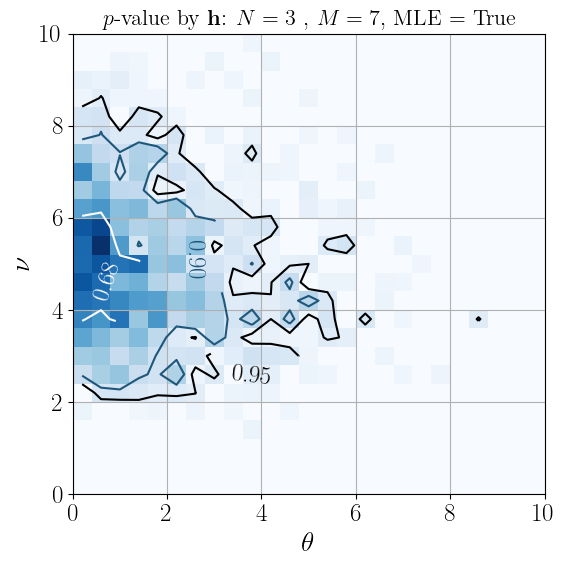

In [10]:

# mpl.rcParams.update(mpl.rcParamsDefault)

figwidth_by_height_ratio=1.33
height=6
width=figwidth_by_height_ratio*height
width=6
fig,ax = plt.subplots(1,1,
                      figsize=(width,height),
                     )

plot_P_byhist_2d(fig=fig, ax=ax, 
             Bprime=100000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=3, M=7,
               nbinstheta=50, nbinsnu=50,                    
                      MLE=True,
             save_plot=True)

# ML
# 3.1: Train on $N,M$ with MLE=True

### Generate Training Data

Generate $\{\theta_i, \nu_i, N_i, M_i, Z_i \}$  data according to the following, and according to whether MLE=True, and save as dataframes

$$
\begin{align}
\theta & \sim \textrm{uniform}(0, 20), \\
\nu & \sim \textrm{uniform}(0, 20), \\
\end{align}
$$


$$
\left\{
\begin{align}
n & \sim \textrm{poisson}(\theta + \nu),\\
m & \sim \textrm{poisson}(\nu),\\
\end{align}
\right\} \rightarrow \lambda_\text{gen}(n, m \mid \theta,\nu)
$$



$$
\left\{
\begin{align}
N & \sim \textrm{uniform}(0,10),\\
M & \sim \textrm{uniform}(0, 10), \\
\end{align}
\right\} \rightarrow \lambda_D(N, M \mid \theta,\nu)
$$


$$
Z_{(\theta,\nu)}  = \mathbb{I}
\left[ \lambda_\text{gen}(n, m \mid \theta,\nu) \leq \lambda_D(N, M \mid \theta,\nu) \right].
$$


### model 1 ("modelNM") is trained on $N,M,\hat{\theta}$ as data:

$$ X_{train} = (\theta_{\text{continuous}}, \nu_{\text{continuous}}, \hat{\theta}_{fixed}, N_{fixed}, M_{fixed} )$$

$$t_{train} = Z_{(\theta,\nu)} $$

In [10]:
thetaMin, thetaMax =  0, 20
numin, numax = 0, 20
Nmin, Nmax =  1,10
Mmin, Mmax =  1 , 10

def generate_training_data_2d(Bprime, MLE, save_data=False):
    """Generate the training data, that is, features=[theta, nu, N, M], targets=Z"""
    #sample theta and nu from uniform(0,20)
    theta = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    # nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    nu= st.uniform.rvs(numin, numax, size=Bprime)
    #n,m ~ F_{\theta,\nu}, ie our simulator. sample n from a Poisson with mean theta+nu 
    n = st.poisson.rvs(theta+ nu, size=Bprime)
    #sample m from a poisson with mean nu
    m = st.poisson.rvs(nu, size=Bprime)
    #sample our observed counts (N,M), which take the place of D
    N = np.random.randint(Nmin, Nmax, size=Bprime)
    M = np.random.randint(Mmin, Mmax, size=Bprime)
    theta_hat_ = theta_hat(N,M, MLE)
    SUBSAMPLE=10
    print('n=', n[:SUBSAMPLE])
    print('m=', m[:SUBSAMPLE])
    print('N=', N[:SUBSAMPLE])
    print('M=', M[:SUBSAMPLE])
    lambda_gen = lambda_test_2d(n, m, theta, nu, MLE)
    print('lambda_gen= ', lambda_gen[:SUBSAMPLE])
    lambda_D = lambda_test_2d(N, M, theta, nu, MLE)
    
    print('lambda_D= ', lambda_D[:SUBSAMPLE])
    #if lambda_gen <= lambda_D: Z=1, else Z=0
    Z = (lambda_gen <= lambda_D).astype(np.int32)
    
    data_2_param = {'Z' : Z, 'theta' : theta, 'nu': nu, 'theta_hat': theta_hat_, 'N':N, 'M':M, 'lambda_D': lambda_D}

    data_2_param = pd.DataFrame.from_dict(data_2_param)
    PATH = os.path.join(LFI_PIVOT_BASE, 
                        'data',
                        'TWO_PARAMETERS_WITH_LAMBDA_D_theta_%s_%s_%sk_Examples_MLE_%s.csv' % (str(thetaMin), str(thetaMax), str(int(Bprime/1000)), str(MLE)) )
    if save_data:
        data_2_param.to_csv(PATH)

    print('\n')
    print(data_2_param.describe())
    return data_2_param

In [7]:
class RegularizedRegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.ReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

In [8]:
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)
def average_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)


def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)


def train(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window, MLE, with_lambda_D):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    

    
    if MLE==True:
        train_t, train_x, test_t,  test_x = getwholedata_2d(MLE_or_nonMLE=True, valid=False, with_lambda_D=with_lambda_D)
    else:
        train_t, train_x, test_t,  test_x = getwholedata_2d(MLE_or_nonMLE=False, valid=False, with_lambda_D=with_lambda_D)
        
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      


        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, test_x[:n], test_t[:n])
            
            #using Ali's loader
            # acc_t = validate(model, avloss, batch_x, batch_t) 
            # acc_v = validate(model, avloss, batch_x_eval, batch_t_eval)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

def plot_average_loss(traces, ftsize=18,save_loss_plots=False):
    
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4.5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')
    #ax.plot(xx, yy_v_avg, 'g', lw=2, label='Running average')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    if save_loss_plots:
        plt.savefig('images/loss_curves/IQN_'+N+T+'_Consecutive_2.png')
        print('\nloss curve saved in images/loss_curves/IQN_'+N+target+'_Consecutive.png')
    # if show_loss_plots:
    plt.show()

### Generate Data with MLE=True

In [13]:
Train_data_2d_MLE_True = generate_training_data_2d(Bprime=1000000, MLE=True, save_data=True)
n_features = Train_data_2d_MLE_True.shape[1]
Train_data_2d_MLE_True.head()

n= [15 10 28 15 15  6 27 23  5 19]
m= [ 5  4 16  7  8  8 17  5  0  6]
N= [4 1 3 5 7 8 1 3 3 9]
M= [4 5 5 2 4 5 6 6 1 3]
lambda_gen=  [1.7199225  0.01397284 0.93508981 2.51459769 0.03337954 1.1675325
 0.93404024 4.60289917 2.22998823 0.21721402]
lambda_D=  [16.26721146 14.08301658 38.52050598 23.72261752  8.45256333  1.42624124
 66.53328335 32.87443368  2.6761389   7.61306384]


                    Z           theta              nu       theta_hat  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.961022       10.001202        9.999901       -0.006042   
std          0.193543        5.774584        5.775469        3.649301   
min          0.000000        0.000033        0.000002       -8.000000   
25%          1.000000        4.996771        4.993422       -3.000000   
50%          1.000000        9.998035        9.990127        0.000000   
75%          1.000000       15.007757       15.003738        3.000000   
max          1.000000       19.9999

,Z,theta,nu,theta_hat,N,M,lambda_D
0,1,7.935242,8.395492,0,4,4,16.267211
1,1,6.139615,4.151977,-4,1,5,14.083017
2,1,12.672168,12.870366,-2,3,5,38.520506
3,1,4.584800,11.905427,3,5,2,23.722618
4,1,7.804724,7.900182,3,7,4,8.452563


### Generate Data with MLE=False

In [41]:
Train_data_2d_MLE_False = generate_training_data_2d(Bprime=1000000, MLE=False, save_data=True)
n_features = Train_data_2d_MLE_False.shape[1]
Train_data_2d_MLE_False.head()

n= [27 42 26 22  6  9 22 22 22 14]
m= [ 9 20 23 14  1 16 17  9  5  3]
N= [3 4 7 8 6 5 6 8 6 5]
M= [6 3 7 6 9 7 4 4 8 8]
lambda_gen=  [0.57942709 4.59530814 2.20474197 2.19861713 0.24518166 6.54306519
 0.28426637 1.0382217  0.04817305 0.33928235]
lambda_D=  [37.49840734 53.11704047 27.78523853 12.87753094 28.9668399  15.49837515
 30.33713294 14.84041271 19.20120081 17.38347775]


                    Z           theta            nu       theta_hat  \
count  1000000.000000  1000000.000000  1.000000e+06  1000000.000000   
mean         0.961167       10.004196  1.000016e+01        1.477720   
std          0.193197        5.774554  5.772514e+00        2.113194   
min          0.000000        0.000012  7.698232e-07        0.000000   
25%          1.000000        5.002446  5.003870e+00        0.000000   
50%          1.000000       10.002092  1.000167e+01        0.000000   
75%          1.000000       15.014330  1.499668e+01        3.000000   
max          1.000000       19.999972  1.999996e+0

,Z,theta,nu,theta_hat,N,M,lambda_D
0,1,15.251919,11.474215,0,3,6,37.498407
1,1,15.086652,15.819146,1,4,3,53.117040
2,1,10.079228,16.617979,0,7,7,27.785239
3,1,12.698148,9.160200,2,8,6,12.877531
4,1,6.279396,0.723810,0,6,9,28.966840


In [9]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

def get_batch(x, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return batch_x


def getwholedata_2d(MLE_or_nonMLE, valid=False, with_lambda_D=False):
    if with_lambda_D==True:
        USECOLS=['Z','theta', 'nu', 'lambda_D']
    else:
        USECOLS=['Z','theta', 'nu', 'theta_hat', 'N', 'M']
            
    if MLE_or_nonMLE==True:
        data_path=os.path.join(LFI_PIVOT_BASE, 
                        'data','TWO_PARAMETERS_theta_0_20_1000k_Examples_MLE_True.csv')

        
        data_path=os.path.join(LFI_PIVOT_BASE, 
                        'data','TWO_PARAMETERS_WITH_LAMBDA_D_theta_0_20_1000k_Examples_MLE_True.csv')
        data = pd.read_csv(data_path, 
                     # nrows=SUBSAMPLE,
                     usecols=USECOLS
                    )
        
    else:
        
        data_path=os.path.join(LFI_PIVOT_BASE, 
                        'data','TWO_PARAMETERS_WITH_LAMBDA_D_theta_0_20_1000k_Examples_MLE_False.csv')
        data = pd.read_csv(data_path, 
                     # nrows=SUBSAMPLE,
                     usecols=USECOLS
                    )
        
    train_data, test_data = train_test_split(data, test_size=0.2)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='Z'
    # source = ['theta','nu','theta_hat','N','M']
    USECOLS.pop(0)
    source = USECOLS

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    if valid:
        #if you want to also make a validation data set
        train_data, valid_data = train_test_split(train_data, test_size=0.2)
        valid_data = valid_data.reset_index(drop=True)
        valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    return train_t, train_x, test_t,  test_x

In [14]:
def get_data_sets(simulate_data, batchsize):
    """write custom data generator because who wants to read pytorch's DataLoader source code
    (and its sometimes slow for some reason)"""
    # if simulate_data:
    #     Train_data_MLE_True = generate_training_data(Bprime=100000, MLE=True, save_data=False)
        
    # if SUBSAMPLE:
    #     data=load_df('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv', SUBSAMPLE=10000)#This is MLE DATA!
    # else:
    #     data=load_df('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv')
    # data=load_df('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv')
    data_path=os.path.join(LFI_PIVOT_BASE, 
                    'data','TWO_PARAMETERS_theta_0_20_1000k_Examples_MLE_True.csv')
    data = pd.read_csv(data_path, 
                 # nrows=SUBSAMPLE,
                 usecols=['Z','theta', 'nu', 'theta_hat', 'N', 'M']
                )
    train_data, test_data = train_test_split(data, 
                                         test_size=0.02)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    # train_data, valid_data = train_test_split(train_data, test_size=0.2)
    train_data = train_data.reset_index(drop=True)
    # valid_data = valid_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='Z'
    source = ['theta', 'nu','theta_hat', 'N','M']
    train_t, train_x = split_t_x(train_data, target=target, source=source)
    # valid_t, valid_x = split_t_x(valid_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    
    def training_set_features():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(train_x, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    def evaluation_set_features():
        #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            batch_x = get_batch(test_x,batchsize)
            #index of one of the items in our examples
            yield batch_x


    def training_set_targets():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(train_t, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    def evaluation_set_targets():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(test_t, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    return training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets

### Retrieve $\{ N,M \}$  data (with lambda_D=False) with and MLE=True

In [15]:
train_t, train_x, test_t,  test_x = getwholedata_2d(MLE_or_nonMLE=True, valid=False,with_lambda_D=False)

train_t shape =  (800000,) 

train_x shape =  (800000, 5) 



In [21]:
# BATCHSIZE=batch_size
# training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = \
# get_data_sets(simulate_data=False, batchsize=BATCHSIZE)

# sample_x=next(training_set_features())#this is just to get the dimenstions of one batch
# sample_y=next(training_set_targets())
# #(batchsize,5) for mass
# print('sample x shape', sample_x.shape)
# print('sample t shape', sample_y.shape)

# n_features = sample_x.shape[1]
# print('\n')


In [30]:
BEST_PARAMS = pd.read_csv(os.path.join(LFI_PIVOT_BASE, 
                                       'best_params',
                                       'best_params_Test_Trials.csv'))
print(BEST_PARAMS)

n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
learning_rate =  float(BEST_PARAMS["learning_rate"])
batch_size = int(BEST_PARAMS["batch_size"])

   Unnamed: 0  n_layers  hidden_size  dropout optimizer_name  learning_rate  \
0           0         4           11  0.13208        RMSprop       0.006398   

   batch_size  
0        1000  


In [17]:
def initiate_whose_model(Ali_or_Harrison, MLE):
    whose_model='Ali'

    if whose_model=='Harrison':
        n_layers=5
        hidden_size=5
        dropout=0
        learning_rate=int(1e-3)
        batch_size=64
        optimizer     = torch.optim.Adam(model.parameters(), lr=int(1e-3)) 
        model=Model()
    elif whose_model=='Ali':
        n_layers = int(BEST_PARAMS["n_layers"]) 
        hidden_size = int(BEST_PARAMS["hidden_size"])
        dropout = float(BEST_PARAMS["dropout"])
        optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
        learning_rate =  float(BEST_PARAMS["learning_rate"])
        batch_size = int(BEST_PARAMS["batch_size"])
        model =  RegularizedRegressionModel(
            nfeatures=NFEATURES, 
            ntargets=1,
            nlayers=n_layers, 
            hidden_size=hidden_size, 
            dropout=dropout
            )
        optimizer = getattr(torch.optim, str(optimizer_name) )(model.parameters(), lr=learning_rate)
        
    return n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model, optimizer

In [24]:
with_lambda_D=False
if with_lambda_D==True:
    NFEATURES=3
else:
    NFEATURES=5
    
model_NM_MLE =  RegularizedRegressionModel(
    nfeatures=NFEATURES, 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )

print(model_NM_MLE)

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [27]:
#initiate MLE model 
n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model_NM_MLE, optimizer_NM_MLE = initiate_whose_model('Ali', MLE=True)
print(optimizer_NM_MLE)
print('\n\n')
print(model_NM_MLE)

BATCHSIZE=batch_size
traces_MLE = ([], [], [], [])
traces_step = 200


n_iterations=100000
#train
traces_MLE= train(model=model_NM_MLE, 
              optimizer=optimizer_NM_MLE, 
              avloss=average_quadratic_loss,
              batch_size=BATCHSIZE, 
              n_iterations=n_iterations, 
              traces=traces_MLE, 
              step=traces_step, 
              window=200,
                MLE=True,
                 with_lambda_D=False)

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0063975512794992
    maximize: False
    momentum: 0
    weight_decay: 0
)



RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)
train_t shape =  (800000,) 

train_x shape =  (800000, 5) 

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	 

In [55]:
# n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model_MLE, optimizer_MLE = initiate_whose_model('Ali', MLE=True)
# print(optimizer_MLE)
# print('\n\n')
# print(model_MLE)

# #also initiate non-MLE model
# # n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model_nonMLE, optimizer_nonMLE = initiate_whose_model('Ali', MLE=False)

In [66]:
# n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model_MLE_with_lambda, optimizer_MLE_with_lambda = initiate_whose_model('Ali', MLE=True)
# print(optimizer_MLE)
# print('\n\n')
# print(model_MLE)

# #also initiate non-MLE model
# # n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model_nonMLE, optimizer_nonMLE = initiate_whose_model('Ali', MLE=False)

### Save Trained model if you haven't already

In [50]:
def save_model_2D(model, MLE, with_lambda_D):
    if MLE==True:
        if with_lambda_D==True:
            # model=model_MLE_with_lambda
            MODEL_FILE_NAME='2D_MLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
        else:
            # model=model_MLE_with_lambda
            MODEL_FILE_NAME='2D_MLE_WITHOUT_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
    else:
        if with_lambda_D==True:
            # model=model_MLE_with_lambda
            MODEL_FILE_NAME='2D_NONMLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
        else:
            # model=model_MLE_with_lambda
            MODEL_FILE_NAME='2D_NONMLE_WITHOUT_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
        
    print('saving model with name ', MODEL_FILE_NAME)
    models_path = os.path.join(LFI_PIVOT_BASE, 'models')
    
#     PATH= os.path.join(models_path, 
#     '2D_MLE_%s_Regressor_%sK_training_iter.pt' % ( str(MLE), str(n_iterations/1000) ))
#     with_theta_hat=True
#     if with_theta_hat==True:
#         PATH=os.path.join(models_path, 
#     '2D_MLE_WITH_LAMBDA_D_%s_Regressor_%sK_training_iter_with_theta_hat.pt' % ( str(MLE), str(n_iterations/1000) ))
    
    PATH=os.path.join(models_path, MODEL_FILE_NAME)
    
    torch.save(model.state_dict(),  PATH)

In [51]:
save_model_2D(model=model_NM_MLE, MLE=True, with_lambda_D=True)

NameError: name 'model_NM_MLE' is not defined

-----

## Load trained model on (N,M)

Make sure it's the correct number of in/out features!

In [44]:
with_lambda_D=False
if with_lambda_D==True:
    MODEL_FILE_NAME='2D_MLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
    NFEATURES=3
else:
    MODEL_FILE_NAME='2D_MLE_True_Regressor_1.0K_training_iter_with_theta_hat.pt'
    NFEATURES=5

    
PATH=os.path.join(LFI_PIVOT_BASE, 'models', MODEL_FILE_NAME)

n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
learning_rate =  float(BEST_PARAMS["learning_rate"])
batch_size = int(BEST_PARAMS["batch_size"])

model_lambda_D =  RegularizedRegressionModel(
    nfeatures=NFEATURES, 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )
model_lambda_D.load_state_dict(torch.load(PATH) )
#OR
#model=torch.load(PATH)#BUT HERE IT WILL BE A DICT (CANT BE EVALUATED RIGHT AWAY) DISCOURAGED!
model_lambda_D.eval()
print(model_lambda_D)

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [12]:
def load_2d_train_df(MLE, with_lambda_D):
    """ returns the dataframe, can be used if the dataframe is saved in csv format
    of if it is already in dataframe format (e.g. generated in this notebook). """
    # SUBSAMPLE=int(1e5)
    # if isinstance(df_name,str):
    if with_lambda_D==True:
        USECOLS=['Z','theta', 'nu', 'lambda_D']
    else:
        USECOLS=['Z','theta', 'nu', 'theta_hat', 'N', 'M']
            
    if MLE==True:
        # data_path=os.path.join(LFI_PIVOT_BASE, 
        #                 'data','TWO_PARAMETERS_theta_0_20_1000k_Examples_MLE_True.csv')

        
        data_path=os.path.join(LFI_PIVOT_BASE, 
                        'data','TWO_PARAMETERS_WITH_LAMBDA_D_theta_0_20_1000k_Examples_MLE_True.csv')
        train_df = pd.read_csv(data_path, 
                     # nrows=SUBSAMPLE,
                     usecols=USECOLS
                    )
    

    else:
        data_path=os.path.join(LFI_PIVOT_BASE, 
                        'data','TWO_PARAMETERS_WITH_LAMBDA_D_theta_0_20_1000k_Examples_MLE_False.csv')
        train_df = pd.read_csv(data_path, 
                     # nrows=SUBSAMPLE,
                     usecols=USECOLS
                    )
    return train_df

In [13]:
train_df_MLE = load_2d_train_df(MLE=True, with_lambda_D=True)
train_df_MLE.head()

,Z,theta,nu,lambda_D
0,1,7.935242,8.395492,16.267211
1,1,6.139615,4.151977,14.083017
2,1,12.672168,12.870366,38.520506
3,1,4.584800,11.905427,23.722618
4,1,7.804724,7.900182,8.452563


In [14]:
train_df_MLE = load_2d_train_df(MLE=True, with_lambda_D=False)
train_df_MLE.head()

,Z,theta,nu,theta_hat,N,M
0,1,7.935242,8.395492,0,4,4
1,1,6.139615,4.151977,-4,1,5
2,1,12.672168,12.870366,-2,3,5
3,1,4.584800,11.905427,3,5,2
4,1,7.804724,7.900182,3,7,4


In [15]:
def make_binned_X(X_min, X_max, Nbins):
    X_step = (X_max-X_min) / Nbins
    bins = np.arange(X_min, X_max+X_step, X_step)
    bin_centers = (bins[1:] + bins[:-1])/2
    return np.array(bin_centers)

In [17]:
def make_eval_data_2d_with_NM(Bprime, N, M, nbins_theta, nbins_nu):
    """Make evaluation data composed of: binned theta and nu, and discrete N and M,
    and optionally theta_hat. The theta hat argument accpts an MLE boolean, therefore
    if trained on MLE data, the theta_hat that we use for evaluation is just 
    n-m, including negative values.
    The return value of this function is used as the "eval_data" tensor below
    
    with lambda_D or with NM"""
    #if MLE true, load the model that was trained on MLE data and vice versa
    # N, M = D
    # nbins=NBINS
    # thetamin,thetamax=0,20
    train_df = load_2d_train_df(MLE=True, with_lambda_D=False)
    
    THETA_bin_centers = make_binned_X(X_min=train_df['theta'].min(),
                                      X_max=train_df['theta'].max(), 
                                      Nbins=nbins_theta)
        
    NU_bin_centers = make_binned_X(X_min=train_df['nu'].min(),
                                  X_max=train_df['nu'].max(), 
                                  Nbins=nbins_nu)
        
    # tensor = torch.Tensor([
                           # [x, y, theta_hat(N, M, MLE=True), N, M] 
                           # for (x,y) in zip(THETA_bin_centers,NU_bin_centers)
                          # ])

    tensor = torch.Tensor([
                       [x, y, theta_hat(N, M, MLE=True), N, M] 
                       for x in THETA_bin_centers for y in NU_bin_centers
                      ])

    #zip only traverses the lists monotonically, so experiment to use cross to take every combination of the two lists
    
    return tensor, THETA_bin_centers.ravel(), NU_bin_centers.ravel()

### Check out eval data with N,M

In [36]:
eval_data_example, eval_bins_theta_example, eval_bins_nu_example =make_eval_data_2d_with_NM(
                                                                                    Bprime=100, 
                                                                                    N=1, 
                                                                                    M=3, 
                                                                                    nbins_theta=100,
                                                                                    nbins_nu=100)

In [ ]:
print(eval_data_example[:10])

tensor([[ 0.1000,  0.1000, -2.0000,  1.0000,  3.0000],
        [ 0.1000,  0.3000, -2.0000,  1.0000,  3.0000],
        [ 0.1000,  0.5000, -2.0000,  1.0000,  3.0000],
        [ 0.1000,  0.7000, -2.0000,  1.0000,  3.0000],
        [ 0.1000,  0.9000, -2.0000,  1.0000,  3.0000],
        [ 0.1000,  1.1000, -2.0000,  1.0000,  3.0000],
        [ 0.1000,  1.3000, -2.0000,  1.0000,  3.0000],
        [ 0.1000,  1.5000, -2.0000,  1.0000,  3.0000],
        [ 0.1000,  1.7000, -2.0000,  1.0000,  3.0000],
        [ 0.1000,  1.9000, -2.0000,  1.0000,  3.0000]])


Check out model evaluated at eval data with N,M

In [27]:
# see if you can evalute a model on theee
model(eval_data_example)[:5]

tensor([[0.9461],
        [0.9166],
        [0.8750],
        [0.8217],
        [0.7587]], grad_fn=<SliceBackward0>)

In [36]:
eval_bins_theta_example.shape

(100,)

In [71]:
def usemodel_2d_with_NM(Bprime, train_df, N,M, MLE, nbinstheta, nbinsnu):
    """ make evaluation data and evaluate the model at these data"""
    #Generate evaluation data at those fixed nu, N, M values
    # make_eval_data_2d has the following signature
    #make_eval_data_2d(Bprime, train_df, N, M, nbins_theta, nbins_nu)
    eval_data, eval_bins_theta, eval_bins_nu =make_eval_data_2d_with_NM(Bprime=Bprime, 
                                                                N=N,M=M, 
                                                                nbins_theta=nbinstheta,
                                                               nbins_nu=nbinsnu)#eval data is indipendent of MLE, since its just constants witha theta variable
    
    # if MLE==True:
    #     model=model
    #else load the model trained on non-MLE data
    # PATH='models/MLE_TRUE_Regressor_200.0K_training_iter.pt'
    
    #LOAD TRAINED MODEL
    with_theta_hat=False
    if MLE==True:
        
        PATH=os.path.join(LFI_PIVOT_BASE,
                          'models', 
                          '2D_MLE_True_Regressor_100.0K_training_iter_with_theta_hat.pt')
        
    else:
        PATH=os.path.join(LFI_PIVOT_BASE,
                          'models', 
                          '2D_NONMLE_WITHOUT_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt')
    n_layers = int(BEST_PARAMS["n_layers"]) 
    hidden_size = int(BEST_PARAMS["hidden_size"])
    dropout = float(BEST_PARAMS["dropout"])
    optimizer_name = BEST_PARAMS["optimizer_name"]
    if type(optimizer_name) != str:
        optimizer_name = optimizer_name.to_string().split()[1]
    learning_rate =  float(BEST_PARAMS["learning_rate"])
    batch_size = int(BEST_PARAMS["batch_size"])
    model =  RegularizedRegressionModel(
        nfeatures=5, 
        ntargets=1,
        nlayers=n_layers, 
        hidden_size=hidden_size, 
        dropout=dropout
        )
    #EVALUATE AT AT EVAL_DATA
    model.load_state_dict(torch.load(PATH) )
    model.eval()
    return model(eval_data).view(-1,).detach().numpy(), eval_bins_theta, eval_bins_nu

### Check out model trained on NM prediction

In [39]:
# check it out
usemodel_2d_with_NM(Bprime=1000,
                                  train_df=train_df_MLE,
                                  N=2, M=3, 
                                  MLE=True, nbinstheta=100, nbinsnu=100)[0][:5]

array([0.99698144, 0.988837  , 0.9618853 , 0.88093257, 0.71583885],
      dtype=float32)

In [93]:
phat_MLE, phatbins_theta, phatbins_nu = usemodel_2d_with_NM(Bprime=1000,
                                  train_df=train_df_MLE,
                                  N=2, M=3, 
                                  MLE=True, 
                                nbinstheta=100, 
                                nbinsnu=100)

In [94]:
phatbins_theta.shape

(100,)

In [95]:
phat_MLE.shape

(10100,)

In [96]:
tb, nb = np.meshgrid(phatbins_theta, phatbins_nu)
tb.shape

(101, 100)

In [38]:
#make sure you can reshape it for the contours!
phat_MLE.reshape(tb.shape)

array([[0.9478107 , 0.91915184, 0.8798383 , ..., 1.        , 1.        ,
        1.        ],
       [0.94452024, 0.914003  , 0.8732308 , ..., 1.        , 1.        ,
        1.        ],
       [0.9410352 , 0.9095105 , 0.86712706, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.9999999 , 0.9999999 , 0.9999999 , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.9999999 , 0.9999999 , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.9999999 , ..., 1.        , 1.        ,
        1.        ]], dtype=float32)

### Plot

In [53]:
def plot_P_byhist_2d_with_model_NM(fig, ax, Bprime,
              thetamin, thetamax,
              numin, numax, 
                      N, M,
               nbinstheta, nbinsnu,                    
                      MLE,
                plothist=False,
                 save_plot=False):
    """Plot histogrammed approximation of p-value as well as model evaluation at eval data """
    # GET PVALUE ESTIMATED BY HISSTOGRAMMING APPROXIMATION
    P_theta_nu, bb_theta_edges, bb_nu_edges = make_hist_2d_data_2d_inference(Bprime,
                  thetamin, thetamax,
                  numin, numax, 
                          N, M,
                   nbinstheta, nbinsnu,                    
                          MLE)
    
    bin_centers_theta = (bb_theta_edges[1:]+bb_theta_edges[:-1])/2
    bin_centers_nu = (bb_nu_edges[1:]+bb_nu_edges[:-1])/2
    #WHOLE RANGE
    thetarange = (thetamin, thetamax)
    nurange = (numin, numax)
    # thetarange = (thetamin, 10)
    # nurange = (numin, 10)
    

    #Remember theta is on x and nu on y axes, so next line, each will be 2d
    THETA, NU = np.meshgrid(bin_centers_theta, bin_centers_nu)
    
    THETA_1d, NU_1d = THETA.flatten(), NU.flatten()
    
    P_theta_nu = P_theta_nu.T
    P_theta_nu_byhist = P_theta_nu.flatten()
    
    # GET MODEL ESTIMATION AT SAME DATA
    phat_MODEL, phatbins_theta_MODEL, phatbins_nu_MODEL = usemodel_2d_with_NM(Bprime=Bprime,
                                  train_df=train_df_MLE,
                                  N=N, M=M, 
                                  MLE=MLE, 
                                nbinstheta=nbinstheta, 
                                nbinsnu=nbinsnu)
    if plothist:
    # PLOT PVALUE ESTIMATED BY HISSTOGRAMMING APPROXIMATION
        ax.hist2d(THETA_1d, NU_1d, bins=(nbinstheta, nbinsnu), 
                   range=(thetarange, nurange),
                   weights=P_theta_nu_byhist,
                 cmap='Blues_r'
                 )
    
    CLs=np.array([0.683,0.80, 0.90,0.95])
    
    #To draw contours, the intensity (the p-value) must be 2D again
    P_theta_nu_byhist_2d = P_theta_nu_byhist.reshape(THETA.shape)
    #for contours everything has to be 2d
    
   # CONTOUR LINES FOR PVALUE ESTIMATED BY HISSTOGRAMMING APPROXIMATION
   # AT CHOSEN CLs
    histogram_approx_contours=ax.contour(THETA, 
                                         NU, 
                                         P_theta_nu_byhist_2d,
              extent=(thetamin, thetamax, numin,numax),
              levels=CLs,
                                         linewidths=2,
                        # cmap='gist_earth_r',
                                         cmap='rainbow',
                        label='histogram approx',
                                         linestyles='dashed'
                       )
    
    
    # CONTOUR LINES FOR PVALUE PREDICTED BY MODEL AT CHOSEN CLs
    THETA_MODEL, NU_MODEL = np.meshgrid(phatbins_theta_MODEL, phatbins_nu_MODEL)
    phat_MODEL_CONTOUR = phat_MODEL.reshape(THETA_MODEL.shape)
    phat_MODEL_CONTOUR=phat_MODEL_CONTOUR.T
    model_approx_contours=ax.contour(THETA_MODEL, 
                                     NU_MODEL, 
                                     phat_MODEL_CONTOUR,
          extent=(thetamin, thetamax, numin,numax),
          levels=CLs,
                                     linewidths=2,
                    cmap='rainbow',
                    label='Model prediction'
                   )

    
#     #label the contours
    ax.clabel(histogram_approx_contours, 
              histogram_approx_contours.levels, 
              inline=False,
              fmt='%4.2f', 
              colors='black',
              # manual=True,
              fontsize=22)
    # ax.text(x=0.3, y=4.5, s='$0.68$', fontsize=22, rotation=-70)
    ax.grid(True, which="both", linestyle='-')
    # ax.text(x=5,y=8, s='$N= %s$' % str(N), fontsize=19)
    # ax.text(x=5,y=7, s='$M=%s$' % str(M), fontsize=19)
    ax.text(x=5.5,y=8, s='$N= %s$' % str(N), fontsize=19)
    ax.text(x=5.5,y=7, s='$M=%s$' % str(M), fontsize=19)
    ax.set_xlabel(r'$\mu$',fontsize=24); ax.set_ylabel(r'$\nu$',fontsize=24)
    # ax.set_title(r'$p$-value by $\mathbf{h}$ (dashed) and $\mathbf{f^{\{N,M\}} }$ (solid): $N = %s$ , $M  = %s$, MLE = %s ' % (str(N),str(M), str(MLE)),fontsize=16)
    ax.set_title(r'$p$-value by $\mathbf{h}$ (dashed) and $\mathbf{f^{\{N,M\}} }$ (solid); MLE = %s' %  str(MLE) ,fontsize=16)
    #add contour color bar
    # cbar = fig.colorbar(histogram_approx_contours, ax=ax)
    ax.set_xlim(thetamin, 10)
    ax.set_ylim(numin, 10)
#     ax.legend()
    
    if save_plot == True:
        plt.savefig(os.path.join(os.environ['LFI_PIVOT_BASE'], 'images', 
        f"2D_Hist_thetamin_{thetamin}_thetamax_{thetamax}_numin_{numin}_numax_{numax}_N_{N}_M_{M}_MLE_{str(MLE)}_2D_INFERENCE.eps"))
    plt.tight_layout(); plt.show()

In [54]:
def fig_ax():
    
    figwidth_by_height_ratio=1.33
    height=6
    width=figwidth_by_height_ratio*height
    width=6
    fig,ax = plt.subplots(1,1,
                          figsize=(width,height),
                         )
    return fig, ax

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: The following kwargs were not used by contour: 'label'


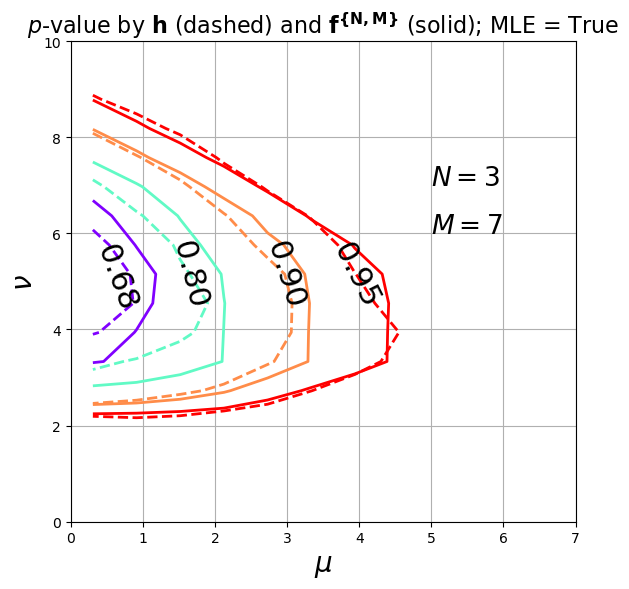

In [83]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_NM(fig=fig, ax=ax, 
             Bprime=100000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=3, M=7,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=True,
                               plothist=False,
             save_plot=True)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: The following kwargs were not used by contour: 'label'


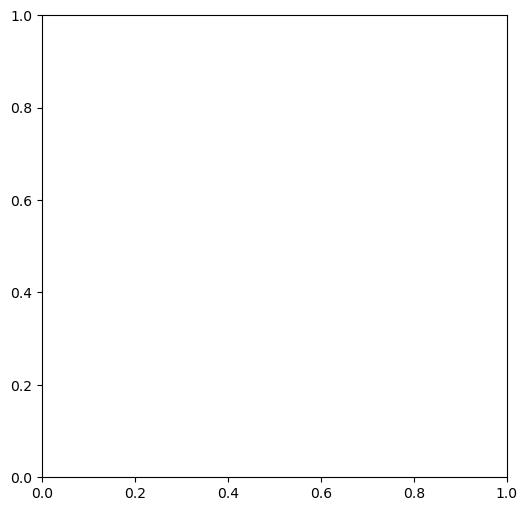

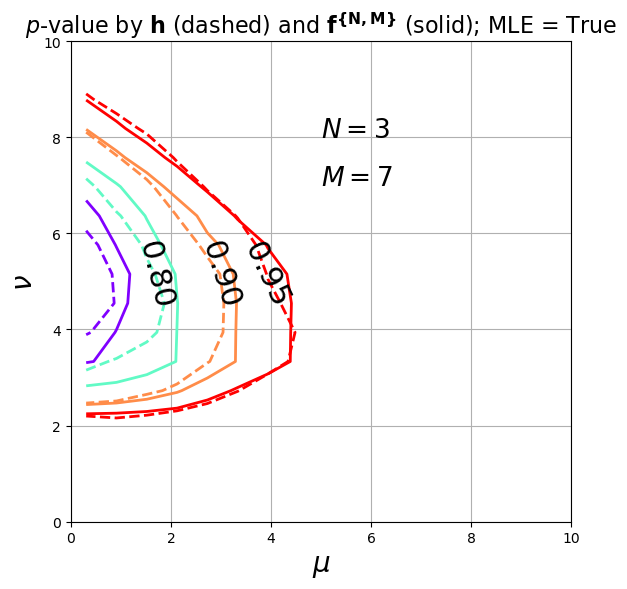

In [99]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_NM(fig=fig, ax=ax, 
             Bprime=100000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=3, M=7,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=True,
                               plothist=False,
             save_plot=True)

### Grenoble Data: $N=3, M=7$

$\mathbf{f^{\{N,M\}} }$  means the model trained on $N,M$ as fixed data.
$\mathbf{f^{\{ \lambda_D \}} }$  means the model trained on $\lambda_D$ as fixed data.


/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: The following kwargs were not used by contour: 'label'


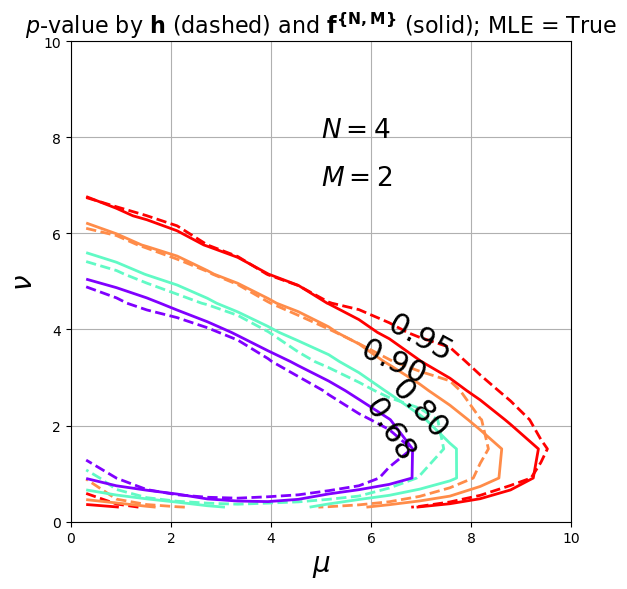

In [97]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_NM(fig=fig, ax=ax, 
             Bprime=10000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=4, M=2,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=True,
             save_plot=True)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: The following kwargs were not used by contour: 'label'


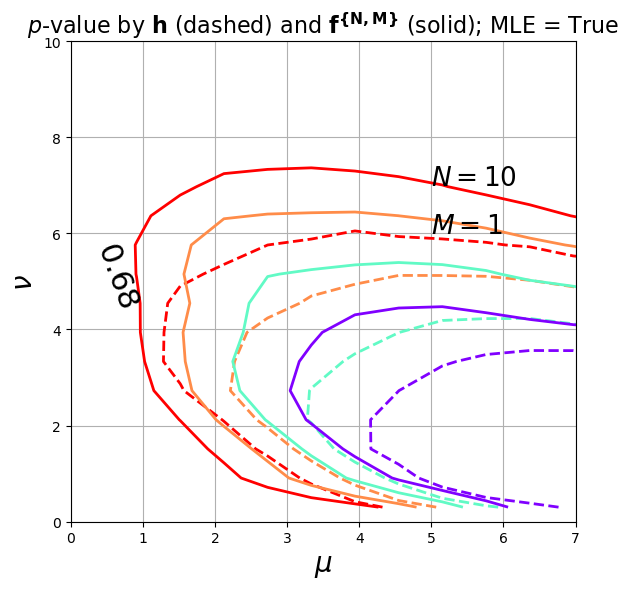

In [87]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_NM(fig=fig, ax=ax, 
             Bprime=10000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=10, M=1,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=True,
             save_plot=True)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: The following kwargs were not used by contour: 'label'


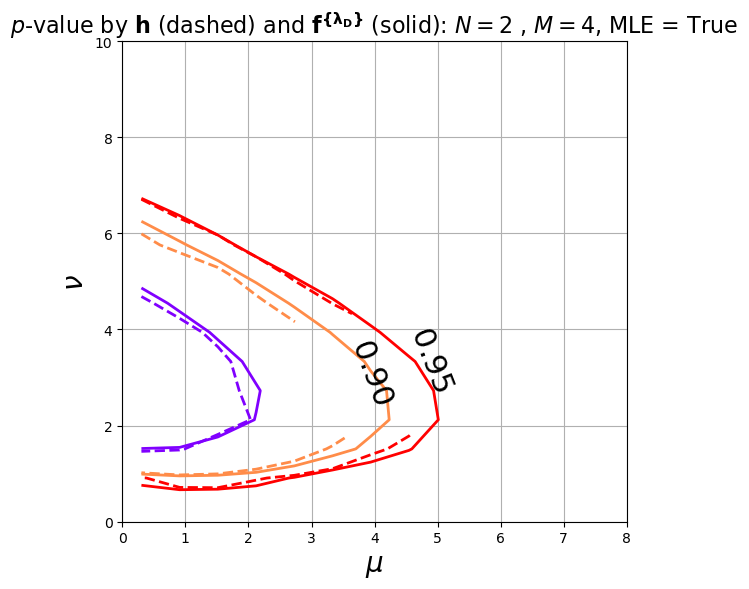

In [66]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_lambda_D(fig=fig, ax=ax, 
             Bprime=10000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=2, M=4,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=True,
             save_plot=True)

---
---

# 3.2 Train on $N,M$ with MLE=False

In [101]:
train_df_nonMLE = load_2d_train_df(MLE=False, with_lambda_D=False)
train_df_nonMLE.head()

,Z,theta,nu,theta_hat,N,M
0,1,15.251919,11.474215,0,3,6
1,1,15.086652,15.819146,1,4,3
2,1,10.079228,16.617979,0,7,7
3,1,12.698148,9.160200,2,8,6
4,1,6.279396,0.723810,0,6,9


In [102]:
with_lambda_D=False
if with_lambda_D==True:
    NFEATURES=3
else:
    NFEATURES=5
    
model_NM_nonMLE =  RegularizedRegressionModel(
    nfeatures=NFEATURES, 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )

print(model_NM_nonMLE)

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [111]:
#initiate MLE model 
n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model_NM_nonMLE, optimizer_NM_nonMLE = initiate_whose_model('Ali', MLE=True)
print(optimizer_NM_nonMLE)
print('\n\n')
print(model_NM_nonMLE)

BATCHSIZE=batch_size
traces_MLE = ([], [], [], [])
traces_step = 200


n_iterations=1000000
#train
traces_MLE= train(model=model_NM_nonMLE, 
              optimizer=optimizer_NM_nonMLE, 
              avloss=average_quadratic_loss,
              batch_size=BATCHSIZE, 
              n_iterations=n_iterations, 
              traces=traces_MLE, 
              step=traces_step, 
              window=200,
                MLE=False,
                 with_lambda_D=False)

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0063975512794992
    maximize: False
    momentum: 0
    weight_decay: 0
)



RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)
train_t shape =  (800000,) 

train_x shape =  (800000, 5) 

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	 

KeyboardInterrupt: 

In [105]:
save_model_2D(model=model_NM_nonMLE, MLE=False, with_lambda_D=False)

Load model

In [108]:
with_lambda_D=False
if with_lambda_D==True:
    MODEL_FILE_NAME='2D_MLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
    NFEATURES=3
else:
    MODEL_FILE_NAME='2D_NONMLE_WITHOUT_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
    NFEATURES=5

    
PATH=os.path.join(LFI_PIVOT_BASE, 'models', MODEL_FILE_NAME)

n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
learning_rate =  float(BEST_PARAMS["learning_rate"])
batch_size = int(BEST_PARAMS["batch_size"])

model_NM_nonMLE =  RegularizedRegressionModel(
    nfeatures=NFEATURES, 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )
model_NM_nonMLE.load_state_dict(torch.load(PATH) )
#OR
#model=torch.load(PATH)#BUT HERE IT WILL BE A DICT (CANT BE EVALUATED RIGHT AWAY) DISCOURAGED!
model_NM_nonMLE.eval()
print(model_NM_nonMLE)

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: The following kwargs were not used by contour: 'label'


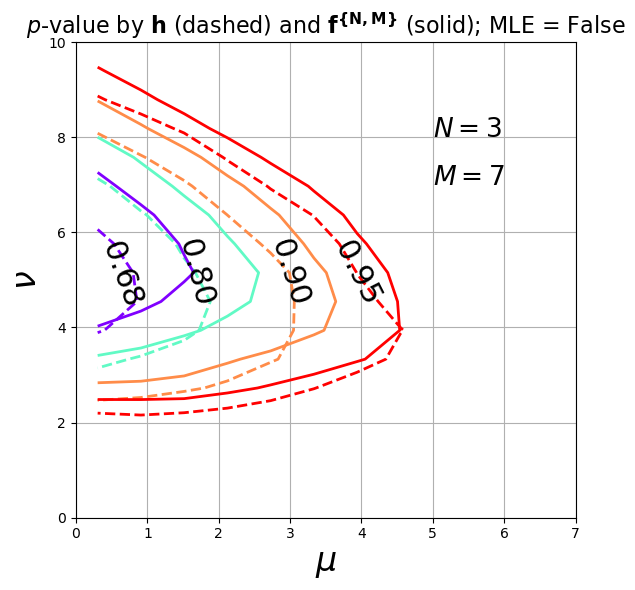

In [114]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_NM(fig=fig, ax=ax, 
             Bprime=100000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=3, M=7,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=False,
                               plothist=False,
                save_plot=True)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: The following kwargs were not used by contour: 'label'


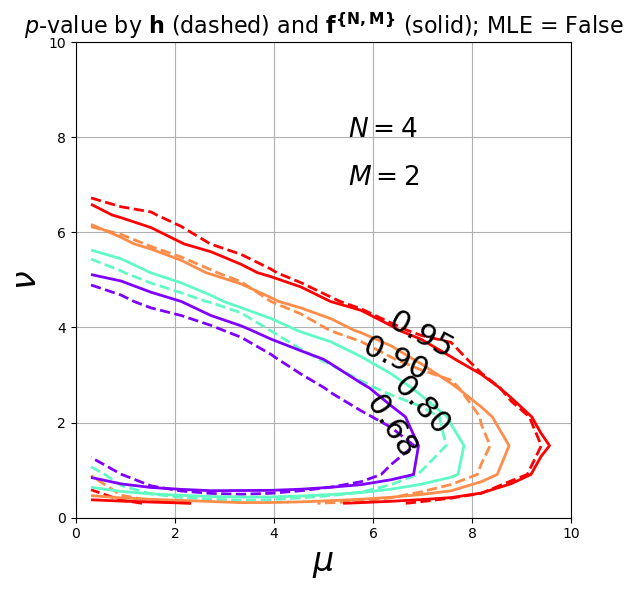

In [116]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_NM(fig=fig, ax=ax, 
             Bprime=10000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=4, M=2,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=False,
             save_plot=True)

----
----

# 3.3 Train on $\lambda_D$ with MLE=True


### model 2 ("model_lambda_D") is trained on $\lambda_D$ as data:

$$ X_{train} = (\theta_{\text{continuous}}, \nu_{\text{continuous}}, \lambda_D )$$

$$t_{train} = Z_{(\theta,\nu)} $$



In [21]:
train_df_MLE = load_2d_train_df(MLE=True, with_lambda_D=True)
train_df_MLE.head()

,Z,theta,nu,lambda_D
0,1,7.935242,8.395492,16.267211
1,1,6.139615,4.151977,14.083017
2,1,12.672168,12.870366,38.520506
3,1,4.584800,11.905427,23.722618
4,1,7.804724,7.900182,8.452563


In [22]:
with_lambda_D=True
if with_lambda_D==True:
    MODEL_FILE_NAME='2D_MLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
    NFEATURES=3
else:
    MODEL_FILE_NAME='2D_NONMLE_WITHOUT_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
    NFEATURES=5
model_lambda_D =  RegularizedRegressionModel(
    nfeatures=NFEATURES, 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )

print(model_lambda_D)

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


# Train MLE Model on $\lambda_D$

In [29]:
#initiate MLE model 
n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model_MLE_with_lambda, optimizer_MLE_with_lambda = initiate_whose_model('Ali', MLE=True)
print(optimizer_MLE_with_lambda)
print('\n\n')
print(model_MLE_with_lambda)

BATCHSIZE=batch_size
traces_MLE = ([], [], [], [])
traces_step = 200


n_iterations=100000
#train
traces_MLE= train(model=model_MLE_with_lambda, 
              optimizer=optimizer_MLE_with_lambda, 
              avloss=average_quadratic_loss,
              batch_size=BATCHSIZE, 
              n_iterations=n_iterations, 
              traces=traces_MLE, 
              step=traces_step, 
              window=200,
                MLE=True,
                 with_lambda_D=True)

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0063975512794992
    maximize: False
    momentum: 0
    weight_decay: 0
)



RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)
train_t shape =  (800000,) 

train_x shape =  (800000, 3) 

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	 

KeyboardInterrupt: 

In [123]:
save_model_2D(model=model_MLE_with_lambda, MLE=True, with_lambda_D=True)

In [27]:
with_lambda_D=True
if with_lambda_D==True:
    MODEL_FILE_NAME='2D_MLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
    NFEATURES=3
else:
    MODEL_FILE_NAME='2D_MLE_True_Regressor_1.0K_training_iter_with_theta_hat.pt'
    NFEATURES=5

    
PATH=os.path.join(LFI_PIVOT_BASE, 'models', MODEL_FILE_NAME)

n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
learning_rate =  float(BEST_PARAMS["learning_rate"])
batch_size = int(BEST_PARAMS["batch_size"])

model_lambda_D =  RegularizedRegressionModel(
    nfeatures=NFEATURES, 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )
model_lambda_D.load_state_dict(torch.load(PATH) )
#OR
#model=torch.load(PATH)#BUT HERE IT WILL BE A DICT (CANT BE EVALUATED RIGHT AWAY) DISCOURAGED!
model_lambda_D.eval()
print(model_lambda_D)

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


### Check out eval data with $\lambda_D$

In [23]:
def make_eval_data_2d_with_lambda_D(Bprime, train_df, N, M, nbins_theta, nbins_nu):
    """Make evaluation data composed of: binned theta and nu, and discrete N and M,
    and optionally theta_hat. The theta hat argument accpts an MLE boolean, therefore
    if trained on MLE data, the theta_hat that we use for evaluation is just 
    n-m, including negative values.
    The return value of this function is used as the "eval_data" tensor below"""
    #if MLE true, load the model that was trained on MLE data and vice versa
    # N, M = D
    # nbins=NBINS
    # thetamin,thetamax=0,20

    THETA_bin_centers = make_binned_X(X_min=train_df['theta'].min(),
                                      X_max=train_df['theta'].max(), 
                                      Nbins=nbins_theta)
        
    NU_bin_centers = make_binned_X(X_min=train_df['nu'].min(),
                                  X_max=train_df['nu'].max(), 
                                  Nbins=nbins_nu)
        
    # tensor = torch.Tensor([
                           # [x, y, theta_hat(N, M, MLE=True), N, M] 
                           # for (x,y) in zip(THETA_bin_centers,NU_bin_centers)
                          # ])
    lambda_D = lambda_test_2d(n=N,m=M,theta=THETA_bin_centers, nu=NU_bin_centers,MLE=True)
    
    if len(lambda_D)==1:
    
        tensor = torch.Tensor([
                           [x, y, lambda_D] 
                           for x in THETA_bin_centers for y in NU_bin_centers
                          ])

    else:
        tensor = torch.Tensor([
            [x, y, lambda_test_2d(n=N,m=M,theta=x, nu=y,MLE=True)]
            for x in THETA_bin_centers for y in NU_bin_centers
        ])
        
    #zip only traverses the lists monotonically, so experiment to use cross to take every combination of the two lists
    
    return tensor, THETA_bin_centers.ravel(), NU_bin_centers.ravel()

In [53]:
eval_data_example, eval_bins_theta_example, eval_bins_nu_example =make_eval_data_2d_with_lambda_D(
                                                                                    Bprime=100,
                                                                                    train_df=
                                                                                    train_df_MLE, 
                                                                                    N=1, M=7,
                                                                                    nbins_theta=33,
                                                                                    nbins_nu=33)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


In [49]:
eval_data_example

tensor([[ 0.1000,  0.1000, 47.2960],
        [ 0.1000,  0.3000, 31.3303],
        [ 0.1000,  0.5000, 24.1681],
        ...,
        [19.9000, 19.5000, 80.1094],
        [19.9000, 19.7000, 80.7564],
        [19.9000, 19.9000, 81.4049]])

### Check out model trained on $\lambda_D$ prediction

In [85]:
def usemodel_2d_with_lambda_D(Bprime, train_df, N, M, MLE, nbinstheta, nbinsnu, PARAMS_DICT=BEST_PARAMS):
    """ make evaluation data and evaluate the model at these data"""
    #Generate evaluation data at those fixed nu, N, M values
    # make_eval_data_2d has the following signature
    #make_eval_data_2d(Bprime, train_df, N, M, nbins_theta, nbins_nu)
    eval_data, eval_bins_theta, eval_bins_nu =make_eval_data_2d_with_lambda_D(Bprime=Bprime,
                                                                train_df=train_df_MLE, 
                                                                N=N, M=M, 
                                                                nbins_theta=nbinstheta,
                                                               nbins_nu=nbinsnu)#eval data is indipendent of MLE, since its just constants witha theta variable
    
    # if MLE==True:
    #     model=model
    #else load the model trained on non-MLE data
    # PATH='models/MLE_TRUE_Regressor_200.0K_training_iter.pt'
    
    #LOAD TRAINED MODEL
    with_theta_hat=False
    if MLE==True:
        MODEL_FILE_NAME='2D_MLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
        PATH=os.path.join(LFI_PIVOT_BASE,
                          'models', 
                          MODEL_FILE_NAME)
        
    else:
        MODEL_FILE_NAME='2D_NONMLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
        PATH=os.path.join(LFI_PIVOT_BASE,
                          'models', 
                          MODEL_FILE_NAME)
        
    n_layers = int(PARAMS_DICT["n_layers"]) 
    hidden_size = int(PARAMS_DICT["hidden_size"])
    dropout = float(PARAMS_DICT["dropout"])
    optimizer_name = PARAMS_DICT["optimizer_name"]
    if type(optimizer_name) != str:
        optimizer_name =optimizer_name.to_string().split()[1]
    learning_rate =  float(PARAMS_DICT["learning_rate"])
    batch_size = int(PARAMS_DICT["batch_size"])
    
    model =  RegularizedRegressionModel(
        nfeatures=3, 
        ntargets=1,
        nlayers=n_layers, 
        hidden_size=hidden_size, 
        dropout=dropout
        )
    #EVALUATE AT AT EVAL_DATA
    print('model path = ', PATH)
    model.load_state_dict(torch.load(PATH) )
    model.eval()
    return model(eval_data).view(-1,).detach().numpy(), eval_bins_theta, eval_bins_nu

In [86]:
# check it out
phat, _, _ = usemodel_2d_with_lambda_D(Bprime=100,
                                  train_df=train_df_MLE,
                                  N=1, M=7,
                                  MLE=True, nbinstheta=33, 
                          nbinsnu=33)
phat

model path =  /home/ali/Desktop/Pulled_Github_Repositories/LFI_HEP/models/2D_MLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt


array([1.       , 0.9999964, 0.9992188, ..., 1.       , 1.       ,
       1.       ], dtype=float32)

In [90]:
def plot_P_byhist_2d_with_model_lambda_D(fig, ax, Bprime,
              thetamin, thetamax,
              numin, numax, 
                      N, M,
               nbinstheta, nbinsnu,                    
                      MLE,
                 PARAMS_DICT,
                plothist=False,
                 save_plot=False):
    """Plot histogrammed approximation of p-value as well as model evaluation at eval data """
    # GET PVALUE ESTIMATED BY HISSTOGRAMMING APPROXIMATION
    P_theta_nu, bb_theta_edges, bb_nu_edges = make_hist_2d_data_2d_inference(Bprime,
                  thetamin, thetamax,
                  numin, numax, 
                          N, M,
                   nbinstheta, nbinsnu,                    
                          MLE)
    
    bin_centers_theta = (bb_theta_edges[1:]+bb_theta_edges[:-1])/2
    bin_centers_nu = (bb_nu_edges[1:]+bb_nu_edges[:-1])/2
    #WHOLE RANGE
    thetarange = (thetamin, thetamax)
    nurange = (numin, numax)
    # thetarange = (thetamin, 10)
    # nurange = (numin, 10)
    

    #Remember theta is on x and nu on y axes, so next line, each will be 2d
    THETA, NU = np.meshgrid(bin_centers_theta, bin_centers_nu)
    
    THETA_1d, NU_1d = THETA.flatten(), NU.flatten()
    
    P_theta_nu = P_theta_nu.T
    P_theta_nu_byhist = P_theta_nu.flatten()
    
    # GET MODEL ESTIMATION AT SAME DATA
    lambda_D = lambda_test_2d(N, M, THETA_1d, NU_1d, MLE)
    phat_MODEL, phatbins_theta_MODEL, phatbins_nu_MODEL = usemodel_2d_with_lambda_D(Bprime=Bprime,
                                  train_df=train_df_MLE,
                                  N=N, M=M,
                                  MLE=MLE, 
                                nbinstheta=nbinstheta, 
                                nbinsnu=nbinsnu,
                                PARAMS_DICT=PARAMS_DICT)
    if plothist:
    # PLOT PVALUE ESTIMATED BY HISSTOGRAMMING APPROXIMATION
        ax.hist2d(THETA_1d, NU_1d, bins=(nbinstheta, nbinsnu), 
                   range=(thetarange, nurange),
                   weights=P_theta_nu_byhist,
                 cmap='Blues_r'
                 )
    
    CLs=np.array([0.683,0.80, 0.90,0.95])
    
    #To draw contours, the intensity (the p-value) must be 2D again
    P_theta_nu_byhist_2d = P_theta_nu_byhist.reshape(THETA.shape)
    #for contours everything has to be 2d
    
   # CONTOUR LINES FOR PVALUE ESTIMATED BY HISSTOGRAMMING APPROXIMATION
   # AT CHOSEN CLs
    histogram_approx_contours=ax.contour(THETA, 
                                         NU, 
                                         P_theta_nu_byhist_2d,
              extent=(thetamin, thetamax, numin,numax),
              levels=CLs,
                                         linewidths=2,
                        # cmap='gist_earth_r',
                                         cmap='rainbow',
                        label='histogram approx',
                                         linestyles='dashed'
                       )
    
    
    # CONTOUR LINES FOR PVALUE PREDICTED BY MODEL AT CHOSEN CLs
    THETA_MODEL, NU_MODEL = np.meshgrid(phatbins_theta_MODEL, phatbins_nu_MODEL)
    phat_MODEL_CONTOUR = phat_MODEL.reshape(THETA_MODEL.shape)
    phat_MODEL_CONTOUR=phat_MODEL_CONTOUR.T
    model_approx_contours=ax.contour(THETA_MODEL, 
                                     NU_MODEL, 
                                     phat_MODEL_CONTOUR,
          extent=(thetamin, thetamax, numin,numax),
          levels=CLs,
                                     linewidths=2,
                    cmap='rainbow',
                    label='Model prediction'
                   )

    
#     #label the contours
    ax.clabel(histogram_approx_contours, 
              histogram_approx_contours.levels, 
              inline=False,
              fmt='%4.2f', 
              colors='black',
              fontsize=22)
    # ax.text(x=0.3, y=4.5, s='$0.68$', fontsize=22, rotation=-70)
    ax.grid(True, which="both", linestyle='-')
    ax.text(x=5.5,y=8, s='$N= %s$' % str(N), fontsize=19)
    ax.text(x=5.5,y=7, s='$M=%s$' % str(M), fontsize=19)
    ax.set_xlabel(r'$\mu$',fontsize=24); ax.set_ylabel(r'$\nu$',fontsize=24)
    # ax.set_title(r'$p$-value by $\mathbf{h}$ (dashed) and $\mathbf{f^{\{N,M\}} }$ (solid): $N = %s$ , $M  = %s$, MLE = %s ' % (str(N),str(M), str(MLE)),fontsize=16)
    ax.set_title(r'$p$-value by $\mathbf{h}$ (dashed) and $\mathbf{f^{\{\lambda_D \}} }$ (solid); MLE = %s' %  str(MLE) ,fontsize=16)    #add contour color bar
    # cbar = fig.colorbar(histogram_approx_contours, ax=ax)
    ax.set_xlim(thetamin, 10)
    ax.set_ylim(numin, 10)
#     ax.legend()
    
    if save_plot == True:
        plt.savefig(os.path.join(os.environ['LFI_PIVOT_BASE'], 'images', 
        f"2D_Hist_LAMBDAD_thetamin_{thetamin}_thetamax_{thetamax}_numin_{numin}_numax_{numax}_N_{N}_M_{M}_MLE_{str(MLE)}_2D_INFERENCE.eps"))
    plt.tight_layout(); plt.show()

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: The following kwargs were not used by contour: 'label'


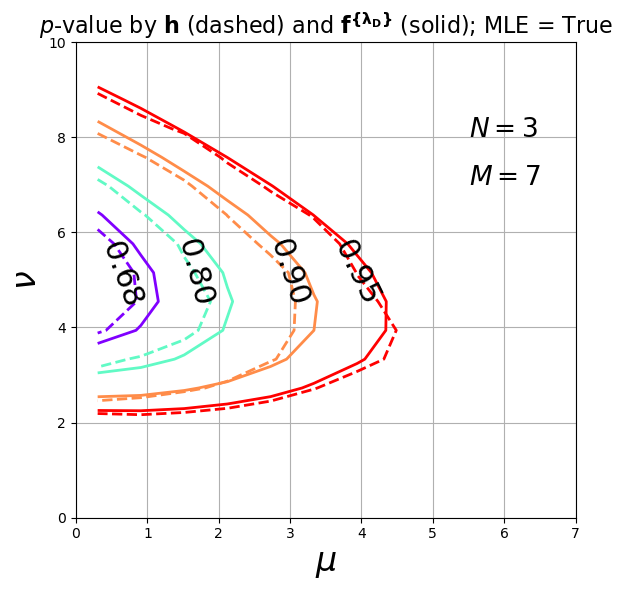

In [58]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_lambda_D(fig=fig, ax=ax, 
             Bprime=100000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=3, M=7,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=True,
                               plothist=False,
             save_plot=True)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: The following kwargs were not used by contour: 'label'


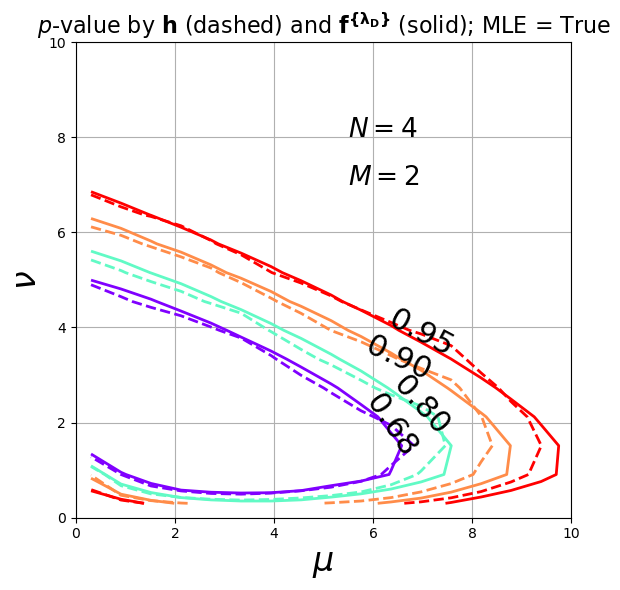

In [62]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_lambda_D(fig=fig, ax=ax, 
             Bprime=100000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=4, M=2,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=True,
                               plothist=False,
             save_plot=True)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: The following kwargs were not used by contour: 'label'


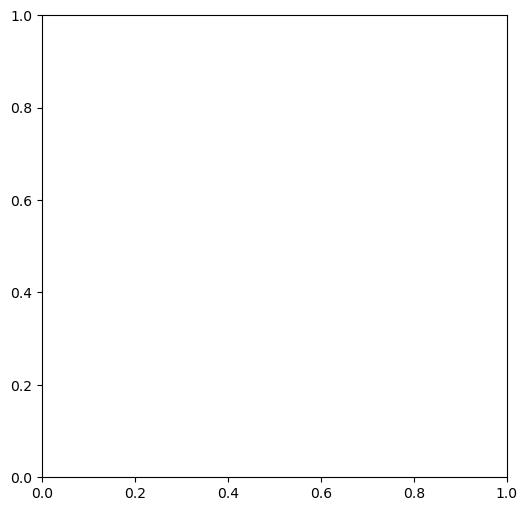

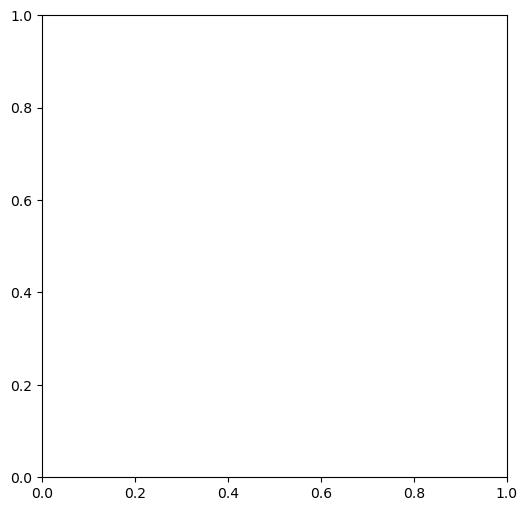

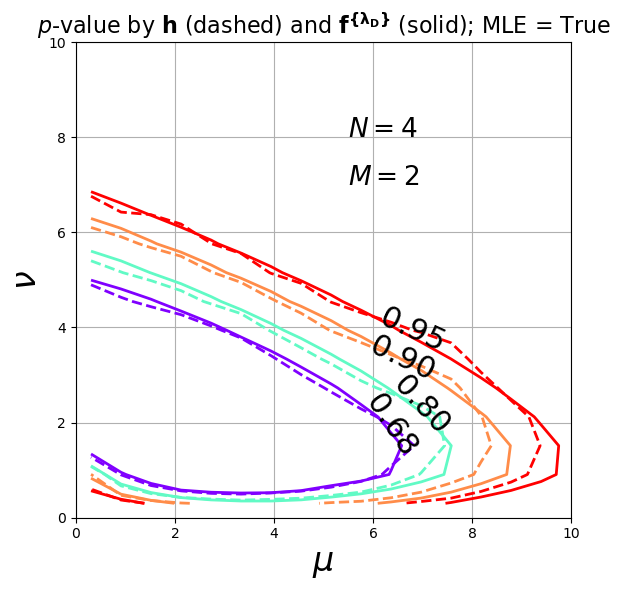

In [33]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_lambda_D(fig=fig, ax=ax, 
             Bprime=10000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=4, M=2,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=True,
                               plothist=False,
             save_plot=False)

# 3.4 Train on $\lambda_D$ with MLE=False


In [26]:
train_df_MLE = load_2d_train_df(MLE=False, with_lambda_D=True)
train_df_MLE.head()

,Z,theta,nu,lambda_D
0,1,15.251919,11.474215,37.498407
1,1,15.086652,15.819146,53.117040
2,1,10.079228,16.617979,27.785239
3,1,12.698148,9.160200,12.877531
4,1,6.279396,0.723810,28.966840


In [34]:
BEST_PARAMS = pd.read_csv(os.path.join(LFI_PIVOT_BASE, 
                                    'best_params',
                                    'best_params_Test_Trials.csv'))
print(BEST_PARAMS)
n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
learning_rate =  float(BEST_PARAMS["learning_rate"])
batch_size = int(BEST_PARAMS["batch_size"])

   Unnamed: 0  n_layers  hidden_size  dropout optimizer_name  learning_rate  \
0           0         4           11  0.13208        RMSprop       0.006398   

   batch_size  
0        1000  


In [79]:
#initiate MLE model 

    
n_layers=20
hidden_size=10 
dropout=0.1
optimizer_name='Adam' 
learning_rate=0.006
batch_size=132 
NFEATURES=3
model_nonMLE_with_lambda=RegularizedRegressionModel(
    nfeatures=NFEATURES, 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )


optimizer_nonMLE_with_lambda=getattr(torch.optim, str(optimizer_name) )(model_nonMLE_with_lambda.parameters(), lr=learning_rate)


print(optimizer_nonMLE_with_lambda)
print('\n\n')
print(model_nonMLE_with_lambda)

BATCHSIZE=batch_size
traces_MLE = ([], [], [], [])
traces_step = 200


n_iterations=10000
#train
traces_MLE= train(model=model_nonMLE_with_lambda, 
              optimizer=optimizer_nonMLE_with_lambda, 
              avloss=average_quadratic_loss,
              batch_size=batch_size, 
              n_iterations=n_iterations, 
              traces=traces_MLE, 
              step=traces_step, 
              window=200,
                MLE=False,
                 with_lambda_D=True)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.006
    maximize: False
    weight_decay: 0
)



RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=10, out_features=10, bias=True)
    (10): Dropout(p=0.1, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=10, bias=True)
    (13): Dropout(p=0.1, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=10, out_features=10, bias=True)
    (16): Dropout(p=0.1, inplace=False)
    (17): ReLU()
    (18): Linear(in_feature

In [80]:
save_model_2D(model=model_nonMLE_with_lambda, MLE=False, with_lambda_D=True)

saving model with name  2D_NONMLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt


In [81]:
PARAM_DICT_2 = {
    'n_layers':20,
'hidden_size':10, 
'dropout':0.1,
'optimizer_name':'Adam', 
'learning_rate':0.006,
'batch_size':132 ,
'NFEATURES':3
}
PARAM_DICT_2

{'n_layers': 20,
 'hidden_size': 10,
 'dropout': 0.1,
 'optimizer_name': 'Adam',
 'learning_rate': 0.006,
 'batch_size': 132,
 'NFEATURES': 3}

model path =  /home/ali/Desktop/Pulled_Github_Repositories/LFI_HEP/models/2D_NONMLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt


/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: The following kwargs were not used by contour: 'label'
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: No contour levels were found within the data range.
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: The following kwargs were not used by contour: 'label'


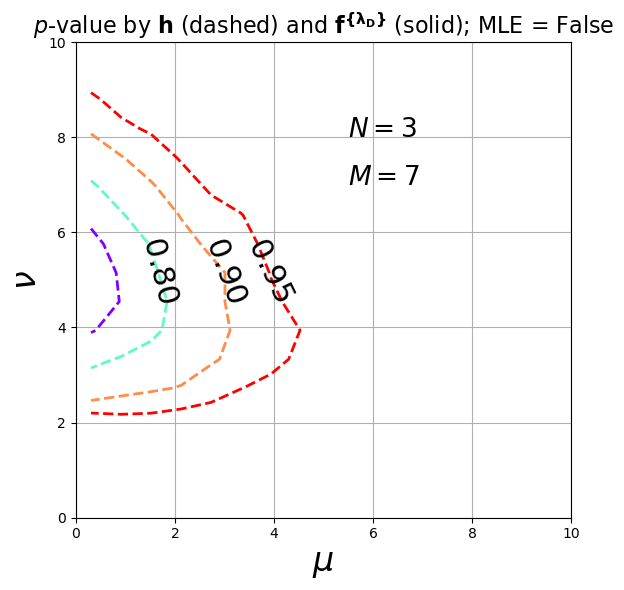

In [87]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_lambda_D(fig=fig, ax=ax, 
       #       Bprime=100000000,
             Bprime=1000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=3, M=7,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=False,
                               plothist=False,
             save_plot=False, 
             PARAMS_DICT=PARAM_DICT_2)

In [ ]:
fig, ax = fig_ax()
plot_P_byhist_2d_with_model_lambda_D(fig=fig, ax=ax, 
             Bprime=100000000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=4, M=2,
               nbinstheta=33, nbinsnu=33,                    
                      MLE=False,
                               plothist=False,
             save_plot=True)

----
----
## Compute Coverage

Get dataframe with $\hat{p}$ computed at every point

In [39]:
eval_df = load_2d_train_df(MLE=True, with_lambda_D=True)


In [34]:
def evaluate_2d_model_on_df(MLE, with_lambda_D):
    """ returns the dataframe, can be used if the dataframe is saved in csv format
    of if it is already in dataframe format (e.g. generated in this notebook). """
    # SUBSAMPLE=int(1e5)
    eval_df = load_2d_train_df(MLE, with_lambda_D)
    #Convert DF to tensor
    eval_tensor= torch.from_numpy(eval_df.to_numpy())
    eval_tensor=eval_tensor.float()
    
    #load model
    if with_lambda_D==True:
        MODEL_FILE_NAME='2D_MLE_WITH_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
        NFEATURES=3
    else:
        MODEL_FILE_NAME='2D_NONMLE_WITHOUT_LAMBDA_D_True_Regressor_10.0K_training_iter_with_theta_hat.pt'
        NFEATURES=5
    
    PATH=os.path.join(LFI_PIVOT_BASE,
                  'models', 
                  MODEL_FILE_NAME)
    
    n_layers = int(BEST_PARAMS["n_layers"]) 
    hidden_size = int(BEST_PARAMS["hidden_size"])
    dropout = float(BEST_PARAMS["dropout"])
    optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
    learning_rate =  float(BEST_PARAMS["learning_rate"])
    batch_size = int(BEST_PARAMS["batch_size"])
    # instantiate model
    model =  RegularizedRegressionModel(
        nfeatures=NFEATURES, 
        ntargets=1,
        nlayers=n_layers, 
        hidden_size=hidden_size, 
        dropout=dropout
        )
    #EVALUATE AT AT EVAL_DATA
    model.load_state_dict(torch.load(PATH) )
    model.eval()
    phat = model(eval_tensor).view(-1,).detach().numpy()
    eval_df['phat']=phat
    return eval_df

In [35]:
phat_df = evaluate_2d_model_on_df(MLE=True, with_lambda_D=True)
phat_df

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000000x4 and 3x11)

$$
\mathbb{PV} (\theta, \nu) =\int_{\lambda_D}^\infty f \big(\lambda_{gen}(n,m \mid \theta,\nu) \mid \theta_{0} \big) \ d \lambda_{gen} 
$$

And since 
$$ 
\int_{- \infty}^{\lambda_D} f \big(\lambda_{gen}(n,m \mid \theta,\nu) \mid \theta_{0} \big) \ d \lambda_{gen} + \int_{\lambda_D}^\infty f \big(\lambda_{gen}(n,m \mid \theta,\nu) \mid \theta_{0} \big) \ d \lambda_{gen} =1
$$

And 
$$ \mathbb{CDF}(\lambda_D; \lambda_{gen}) \equiv \int_{- \infty}^{\lambda_D} f \big(\lambda_{gen}(n,m \mid \theta,\nu) \mid \theta_{0} \big) \ d \lambda_{gen} $$

We can say
$$ \mathbb{PV}(\theta,\nu) = 1 - \mathbb{CDF}(\lambda_D; \lambda_{gen}) $$

In [74]:
# get 68% confidence set
tau=0.68
phat_df_068 = phat_df[phat_df['phat'] <= tau]
phat_df_068.head()

,theta,nu,theta_hat,N,M,phat
10,1.506643,5.172910,6,9,3,0.574145
33,0.925470,8.859741,1,7,6,0.611848
52,9.810942,2.432338,8,9,1,0.531324
56,1.589864,10.508963,0,9,9,0.259103
72,4.379040,4.062182,5,8,3,0.243659


### Coverage algorithm:
1. Get confidence set at $\tau$, which is the dataframe for which $\hat{p}<\tau$
2. Get the $\mu,\nu$ from the desired confidence set $\vec{\theta}_\tau = \{ (\mu,\nu) \}_\tau$
3. For i in range($\vec{\theta}_\tau$):

            Generate $N_i, M_i$ of size 1000 each

            Calculate $\lambda_{D, \tau} =\lambda_D(\mu_{\tau, i}, \nu_{\tau,i}, N_i, M_i)$
    
            calculate $\hat{\hat{p}}=\hat{p}(\mu_i, lambda_{D,\tau})$
    
            calculate $mean(\hat{\hat{p}} < tau)$
    

In [67]:
n_param_points, n_data_points_coverage = 2, 10
coverage = [0] * n_param_points_coverage


What we find is that if we repeat the experiment multiple times at different choices of $N,M$ is that the confidence sets will jump around (they are not fixed) which means that the intervals for $\theta,\nu$ also jump around.

**What we want to do is to find a confidence interval for $\theta$ indpendently of $\nu$. We do this by extension of the confidence set algorithm for $\theta,\nu)$ to a confidence interval on $\theta$ alone.** 

# Mapping Confidence Regions (Sets) to Confidence intervals

We would like to extend map confidence region (or set) $R(D)$ to univariate confidence interval for a particular parameter. What we currently have, is that 
$$\mathbb{P} [ R(D) \text{ will cover the true }\{\theta,\nu\} \text{pair} ] \ge 1-\alpha $$

Or, in other words,

$$\mathbb{P}\left( \theta_0 \in [\theta_{lo},\theta^{up} ] \text{ and } \nu_0 \in [\nu_{lo},\nu^{up} ] \right) \ge 1-\alpha \tag{5} $$

We would like to map the statement in Eq 5 to a confidence interval on an individual parameter
$$\mathbb{P}\left( \theta_0 \in [\theta_{lo},\theta^{up} ] \right) \ge 1-\alpha \tag{5} $$


(Aside: it is interesting to note that the value $\theta_0$ is fixed and unknown while the variables $\theta_{lo},\theta_{up}$ are random variables).


i.e. map The confidence region to a coverage probability of an individual parameter, say parameter of interest

$$\mathbb{CR}({\theta,\nu}) \rightarrow \mathbb{CPI}(\theta)$$


So the NN is just a function of $\theta$ and a particular CL $\tau$ , and gives the coverage probability of an individual parameter $\mathbb{CPI}(\theta,\tau)$ . Once we have this function, we can say "I would like to have a confidence level on $\theta$ of 68%, and a way to achieve that is to construct a set whose coverage probability is 73%. 
 
 
Currently, we can't do that mapping because we only have the confidence region, i.e. a confidence interval on one parameter only in the existence of the confidence interval on the other parameter. We would like to do it globally, such that if we have confidence region, we can map that to confidence interval of other parameter regardless of the value of the other parameter. We use the Gaussian conffidence ellipse as a heuristic motivation of what we would like to do.

## Check coverage of the set at several $\tau$ values and observe that for the 1D case, using our 2D algorithm the coverage is not exact

## Algorithm

We want an input being the data $D$ and paramters $\theta$ generated on-the-fly, and the output being a CI on a parameter. 

Another advantage of this approach is that it can be done in an arbitrary number of dimensions
 
The essential idea of the algorithm is to simply generate parameter points inside a particular confidence set, and take the minimum and maximum of those points as the upper and lower confidence intervals. Once you have the edges of a parameter at a particular CL, you can map the CS to the CI of that parameter at that CL.


Essentially, for a given CL, we have the contours in the region, so the edges of a parameter at the given CL can be found
$$\{ \vec{\mu}_{edge}^{CL}, \vec{\nu}_{edge}^{CL} \}=  \{ \vec{\mu}, \vec{\nu} : \hat{p} \le CL \}$$

So that the intervals for a parameter at a given CL is simply
$$(\mu_{lo}, \mu_{up} ) = \left( min(\vec{\mu}_{edge}^{CL}), max(\vec{\mu}_{edge}^{CL}) \right)  $$

(idea another way we can do this is potentially to use $\lambda_{2D}$ to get the confidence set, but then use $\lambda_{1D}(\theta)$ to get the interval of $\theta$ within the set. 

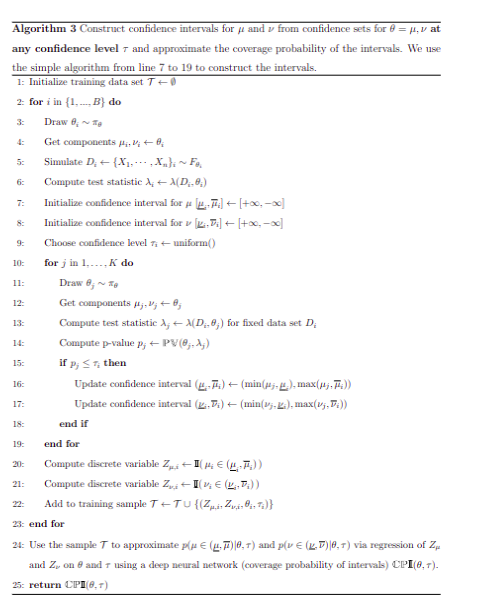

In [5]:
display(Image(os.path.join(LFI_PIVOT_BASE,'images','Confidence_set_any_tau_algorithm.png')))

The first step is that we need a dataset with the estimated p-value at each datapoint

In [36]:
ev_t=torch.from_numpy(train_df_MLE[['theta', 'nu', 'theta_hat', 'N', 'M']].to_numpy())
ev_t=ev_t.float()
# ev_t = ev_t.T

In [48]:
model.eval()
model(ev_t)

tensor([[0.4487],
        [0.4715],
        [0.4503],
        ...,
        [0.4648],
        [0.4544],
        [0.4552]], grad_fn=<SigmoidBackward0>)

Pick out a confidence set. A confidence set is given by
$$\mathbb{P}(\lambda \le \lambda_0 \mid \theta_0) \le \tau$$

In [39]:
# X, Y = np.meshgrid(phat_df_068['theta'], phat_df_068['nu'])
# phat_df_068 = phat_df_068['phat'].to_numpy()
# plt.hist2d(phat_df_068['theta'], phat_df_068['nu'], weights=phat_df_068['phat'])
# plt.show()

In [32]:
np.array(1 <= 5 <= 10).astype(int) 

array(1)

In [37]:
def generate_confidence_set_data_for_given_tau(df, tau):
    tau=float(tau)
    phat_df_tau = df[df['phat'] <= tau]
    
    theta_edge = phat_df_tau['theta']
    nu_edge = phat_df_tau['nu']
    theta_lo, theta_up = min(theta_edge), max(theta_edge)
    print(f'at {tau} CL, (theta_lo, theta_up)= {theta_lo}, {theta_up} )')
    nu_lo, nu_up = min(nu_edge), max(nu_edge)
    print(f'at {tau} CL, (nu_lo, nu_up)= {nu_lo}, {nu_up} )')
    def is_between(low,high,val):
        low,high,val = float(low),float(high),float(val)
        Z = np.array(low <= val <= high).astype(int)
        return Z
    Z_theta_l, Z_nu_l = [], []
    for ind, row in df.iterrows():
        theta, nu = row['theta'], row['nu']
        Z_theta = is_between(theta_lo, theta_up, theta)
        Z_nu = is_between(nu_lo, nu_up, nu)
        # df.loc[ind, 'Z_theta'] = Z_theta
        # df['Z_nu']=Z_nu
        Z_theta_l.append(Z_theta)
    df['Z_theta'] = Z_theta_l
    
    
    # data = phat_df_tau.to_numpy()
    df.to_csv(os.path.join(LFI_PIVOT_BASE, 'data', 
                           'Z_theta_Z_nu_Confidence_Set_Data_Tau_68.csv'))
    return df
    

In [38]:
dd = generate_confidence_set_data_for_given_tau(df=phat_df[:1000], tau=0.68)

NameError: name 'phat_df' is not defined

In [81]:
dd

,theta,nu,theta_hat,N,M,phat
0,3.557383,11.440410,2,4,2,0.999998
1,11.598479,4.503764,5,9,4,0.905840
2,11.626689,11.343044,4,8,4,0.999997
3,17.900354,0.329772,-5,3,8,1.000000
4,8.989809,6.036802,-1,2,3,0.999961
...,...,...,...,...,...,...
995,17.149544,4.878327,6,9,3,0.999284
996,1.277430,16.458159,0,5,5,1.000000
997,18.961302,3.279090,-7,1,8,1.000000
998,4.034487,0.953814,7,8,1,0.619799


In [36]:
df_68 = pd.read_csv(os.path.join(LFI_PIVOT_BASE, 'data', 
                           'Z_theta_Z_nu_Confidence_Set_Data_Tau_68.csv'))
df_68.describe()

,Unnamed: 0,theta,nu,theta_hat,N,M,phat,Z_theta
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,10.063233,10.105382,0.033000,5.117000,5.084000,0.959973,0.553000
std,288.819436,5.807983,5.653278,3.687751,2.665035,2.558415,0.132278,0.497432
min,0.000000,0.064964,0.002273,-8.000000,1.000000,1.000000,0.243659,0.000000
25%,249.750000,5.033145,5.257369,-3.000000,3.000000,3.000000,0.999308,0.000000
50%,499.500000,10.033437,10.281782,0.000000,5.000000,5.000000,0.999998,1.000000
75%,749.250000,14.996700,15.002229,3.000000,8.000000,7.000000,1.000000,1.000000
max,999.000000,19.996722,19.998460,8.000000,9.000000,9.000000,1.000000,1.000000


In [47]:
df_68['Z_nu'].sum()

0

----
----
----
----
----

# Only 1D inference on $\theta$ (independently of $\nu$)

In [15]:
def make_hist_2d_data(Bprime,
              thetamin, thetamax,
              numin, numax, 
                      N, M,
               nbinstheta, nbinsnu,                    
                      MLE):

    theta = st.uniform.rvs(thetamin, thetamax, size=Bprime)
    nu = st.uniform.rvs(numin, numax, size=Bprime)
    n = st.poisson.rvs(theta + nu, size=Bprime)
    m = st.poisson.rvs(nu, size=Bprime)
    
    Z = (lambda_test(theta, n, m, MLE=MLE) < 
         lambda_test(theta, N, M, MLE=MLE)).astype(np.int32)

    thetarange = (thetamin, thetamax)
    nurange = (numin, numax)
    # bins = binsize(Bprime)

    # Z-weighted histogram   (count the number of ones per bin)
    #theta will be on axis and nu on y axis
    y_theta_nu_w, bb_theta_edges, bb_nu_edges = np.histogram2d(theta, nu,
                          bins=(nbinstheta, nbinsnu), 
                          range=(thetarange, nurange), 
                          weights=Z)
    
    # unweighted histogram (count number of ones and zeros per bin)
    y_theta_nu_uw, bb_theta_edges, bb_nu_edges = np.histogram2d(theta, nu,
                          bins=(nbinstheta, nbinsnu), 
                          range=(thetarange, nurange))
    eps=1e-15
    P_theta_nu =  y_theta_nu_w / (y_theta_nu_uw + eps)    
    #P_theta_nu approximates E[Z]
    return P_theta_nu, bb_theta_edges, bb_nu_edges

In [16]:
P_theta_nu, bb_theta_edges, bb_nu_edges = make_hist_2d_data(Bprime=1000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=4, M=2,
               nbinstheta=100, nbinsnu=100,                    
                      MLE=False)
print(P_theta_nu.shape)
print(bb_theta_edges.shape)

(100, 100)
(101,)


In [49]:
def plot_P_byhist(fig, ax, Bprime,
              thetamin, thetamax,
              numin, numax, 
                      N, M,
               nbinstheta, nbinsnu,                    
                      MLE,
                 save_plot=False):
    
    P_theta_nu, bb_theta_edges, bb_nu_edges = make_hist_2d_data(Bprime,
                  thetamin, thetamax,
                  numin, numax, 
                          N, M,
                   nbinstheta, nbinsnu,                    
                          MLE)
    
    bin_centers_theta = (bb_theta_edges[1:]+bb_theta_edges[:-1])/2
    bin_centers_nu = (bb_nu_edges[1:]+bb_nu_edges[:-1])/2
    
    thetarange = (thetamin, thetamax)
    nurange = (numin, numax)
    
    
    #Remember theta is on x and nu on y axes, so next line, each will be 2d
    THETA, NU = np.meshgrid(bin_centers_theta, bin_centers_nu)
    
    THETA_1d, NU_1d = THETA.flatten(), NU.flatten()
    
    P_theta_nu = P_theta_nu.T
    P_theta_nu_byhist = P_theta_nu.flatten()
    
    ax.hist2d(THETA_1d, NU_1d, bins=(nbinstheta, nbinsnu), 
               range=(thetarange, nurange),
               weights=P_theta_nu_byhist,
             # cmap='Blues_r'
             )
    
    CLs=np.array([0.683,0.90,0.95])
    
    #To draw contours, the intensity (the p-value) must be 2D again
    P_theta_nu_byhist_2d = P_theta_nu_byhist.reshape(THETA.shape)
    #for contours everything has to be 2d
    contours=ax.contour(THETA, NU, P_theta_nu_byhist_2d,
              extent=(thetamin, thetamax, numin,numax),
              levels=CLs)
    
#     #label the contours
    ax.clabel(contours, contours.levels, inline=True,
              fmt='%4.2f', colors='red',fontsize=16)
    ax.grid()
    ax.set_xlabel(r'$\theta$',fontsize=16); ax.set_ylabel(r'$\nu$',fontsize=16)
    ax.set_title(r'$p_\theta$-value by $\mathbf{h}$: $N = %s$ , $M  = %s$, MLE = %s ' % (str(N),str(M), str(MLE)),fontsize=16)
    #add contour color bar
    cbar = fig.colorbar(contours, ax=ax)
    
    if save_plot == True:
        plt.savefig(os.path.join(os.environ['LFI_PIVOT_BASE'], 'images', f"2D_Hist_thetamin_{thetamin}_thetamax_{thetamax}_numin_{numin}_numax_{numax}.png"))
    plt.tight_layout(); plt.show()

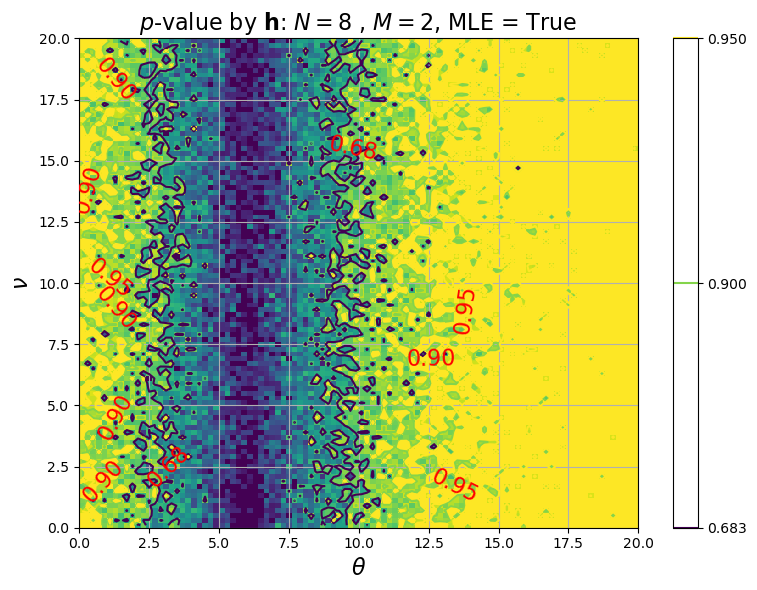

In [24]:
figwidth_by_height_ratio=1.33
height=6
width=figwidth_by_height_ratio*height
fig,ax = plt.subplots(1,1,
                      figsize=(width,height),
                     )

plot_P_byhist(fig=fig, ax=ax, 
             Bprime=100000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=8, M=2,
               nbinstheta=100, nbinsnu=100,                    
                      MLE=True,
             save_plot=True)
# plot_P_byhist(ax=ax[1], 
#              Bprime=100000,
#               thetamin=0, thetamax=20,
#               numin=0, numax=20, 
#                       N=8, M=2,
#                nbinstheta=100, nbinsnu=100,                    
#                       MLE=False)

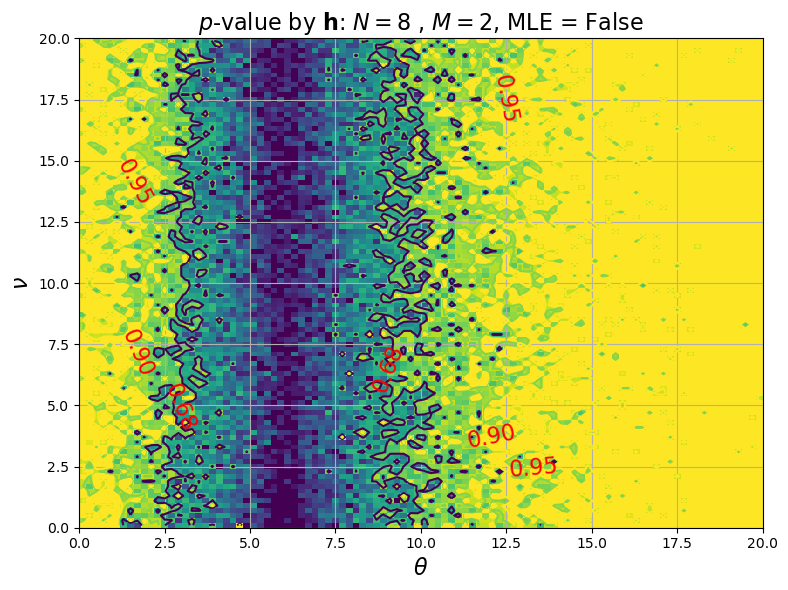

In [33]:

fig,ax = plt.subplots(1,1,
                      figsize=(width,height)
                     )

plot_P_byhist(ax=ax, 
             Bprime=100000,
              thetamin=0, thetamax=20,
              numin=0, numax=20, 
                      N=8, M=2,
               nbinstheta=100, nbinsnu=100,                    
                      MLE=False)

--------------

# ML

And the whole ML logic in estimating this and making inference in 2D applies:

### First load the training data we used previously (in notebook 2)

In [18]:
def load_train_df(MLE):
    """ returns the dataframe, can be used if the dataframe is saved in csv format
    of if it is already in dataframe format (e.g. generated in this notebook). """
    # SUBSAMPLE=int(1e5)
    # if isinstance(df_name,str):
    if MLE:
        train_df = pd.read_csv(
            os.path.join(LFI_PIVOT_BASE,'data','two_parameters_theta_0_20_1000k_Examples_MLE_True.csv'), 
                         # nrows=SUBSAMPLE,
                         usecols=['Z','theta', 'nu', 'theta_hat', 'N', 'M']
                        )
    else:
        train_df = pd.read_csv(
            os.path.join(LFI_PIVOT_BASE, 'data','two_parameters_theta_0_20_1000k_Examples_MLE_False.csv'), 
                 # nrows=SUBSAMPLE,
                 usecols=['Z','theta', 'nu', 'theta_hat', 'N', 'M']
                )
    return train_df


In notebook 2, we trained the model on continuous $\theta, \nu$ :

$$ X_{train} = (\theta_{\text{continuous}}, \nu_{\text{continuous}}, \hat{\theta}_{fixed}, N_{fixed}, M_{fixed} ),$$


In [23]:
train_df_MLE = load_train_df(MLE=True)
train_df_MLE.head()

,Z,theta,nu,theta_hat,N,M
0,1,14.224636,19.888336,-6,3,9
1,1,4.298885,1.224232,3,4,1
2,1,16.724410,11.147011,1,4,3
3,1,0.399752,11.743650,2,6,4
4,1,6.909235,2.207732,-3,4,7


In [24]:
train_df_nonMLE = load_train_df(MLE=False)
train_df_nonMLE.head()

,Z,theta,nu,theta_hat,N,M
0,1,11.282337,10.868814,0,3,9
1,1,14.088345,7.463724,7,9,2
2,1,13.291443,10.772238,2,4,2
3,1,19.687959,6.578690,4,5,1
4,1,7.525728,5.680840,0,1,9


where some models were trained on $\hat{\theta}$ (obviously fixed since $N,M$ are fixed and $\hat{\theta}=N-M$) and some were not trained on $\hat{\theta}$ (for science, which produced similar results - no difference on whether $\hat{\theat}$ helps the NN train better ).

but since $L_{prof}$ is only a function of $\theta$ ($\nu$ was profiled out), our hypothesis testing was only testing $\theta$; it was evaluated on the following:

$$ X_{\text{eval}} = (\theta_{\text{continuous}}, \nu_{\text{fixed}}, \hat{\theta}_{fixed}, N_{fixed}, M_{fixed} )$$


In [15]:
def make_eval_data(Bprime, train_df, nu, N, M, nbins):
    #if MLE true, load the model that was trained on MLE data and vice versa
    # N, M = D
    # nbins=NBINS
    # thetamin,thetamax=0,20
    #this is to make sure its taking theta values fron the range we trained it on
    thetamin=train_df['theta'].min()
    thetamax=train_df['theta'].max()
    thetastep = (thetamax-thetamin) / nbins#Delta theta (bin width)
    bb    = np.arange(thetamin, thetamax+thetastep, thetastep)#this is just making a vector of thetas
    X     = (bb[1:] + bb[:-1])/2#at the center
    tensor = torch.Tensor([[x, nu, theta_hat(N, M, MLE=True), N, M] for x in X])
    return tensor, X.ravel()

In [22]:
eval_data_example, eval_bins_example =make_eval_data(Bprime=100,train_df=train_df_MLE,
                                                     nu=3, N=1, M=3, nbins=300)
print(eval_data_example[:5])

tensor([[ 0.0333,  3.0000, -2.0000,  1.0000,  3.0000],
        [ 0.1000,  3.0000, -2.0000,  1.0000,  3.0000],
        [ 0.1667,  3.0000, -2.0000,  1.0000,  3.0000],
        [ 0.2333,  3.0000, -2.0000,  1.0000,  3.0000],
        [ 0.3000,  3.0000, -2.0000,  1.0000,  3.0000]])


To make inference on $\theta$

In [12]:
def getwholedata(MLE_or_nonMLE, valid=False):
    if MLE:
        data = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_True.csv', 
                     # nrows=SUBSAMPLE,
                     usecols=['Z','theta', 'nu', 'theta_hat', 'N', 'M']
                    )
        
    else:
        data = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_False.csv', 
             # nrows=SUBSAMPLE,
             usecols=['Z','theta', 'nu', 'theta_hat', 'N', 'M']
            )
    train_data, test_data = train_test_split(data, test_size=0.2)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='Z'
    source = ['theta','nu','theta_hat','N','M']

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    if valid:
        #if you want to also make a validation data set
        train_data, valid_data = train_test_split(train_data, test_size=0.2)
        valid_data = valid_data.reset_index(drop=True)
        valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    return train_t, train_x, test_t,  test_x